# Doc24: прогностическая модель рисков беременных

**Задача:** создать прогностическую модель рисков беременных.\
**Метрика:** определяется самостоятельно.

**Описание данных:**
- Age: Age in years when a woman is pregnant.
- SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
- HeartRate: A normal resting heart rate in beats per minute.
- Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

## Импорт библиотек

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Обзор данных

In [3]:
data = pd.read_csv("Maternal Health Risk Data Set.csv")

In [4]:
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Первые 5 строк'}\033[0m")
display(data.head())
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Основная информация по таблице'}\033[0m")
data.info()
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Пропуски в таблице'}\033[0m")
print(data.isna().sum())
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Количество дубликатов в таблице'}\033[0m")
display(data.duplicated().sum())
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Основная статистическая информация о таблице'}\033[0m")
display(data.describe())
print('-----------------------------------------------------------------------')

-----------------------------------------------------------------------
Первые 5 строк


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


-----------------------------------------------------------------------
Основная информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
-----------------------------------------------------------------------
Пропуски в таблице
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
-----------------------------------------------------------------------
Количество дубликатов в таблице


562

-----------------------------------------------------------------------
Основная статистическая информация о таблице


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


-----------------------------------------------------------------------


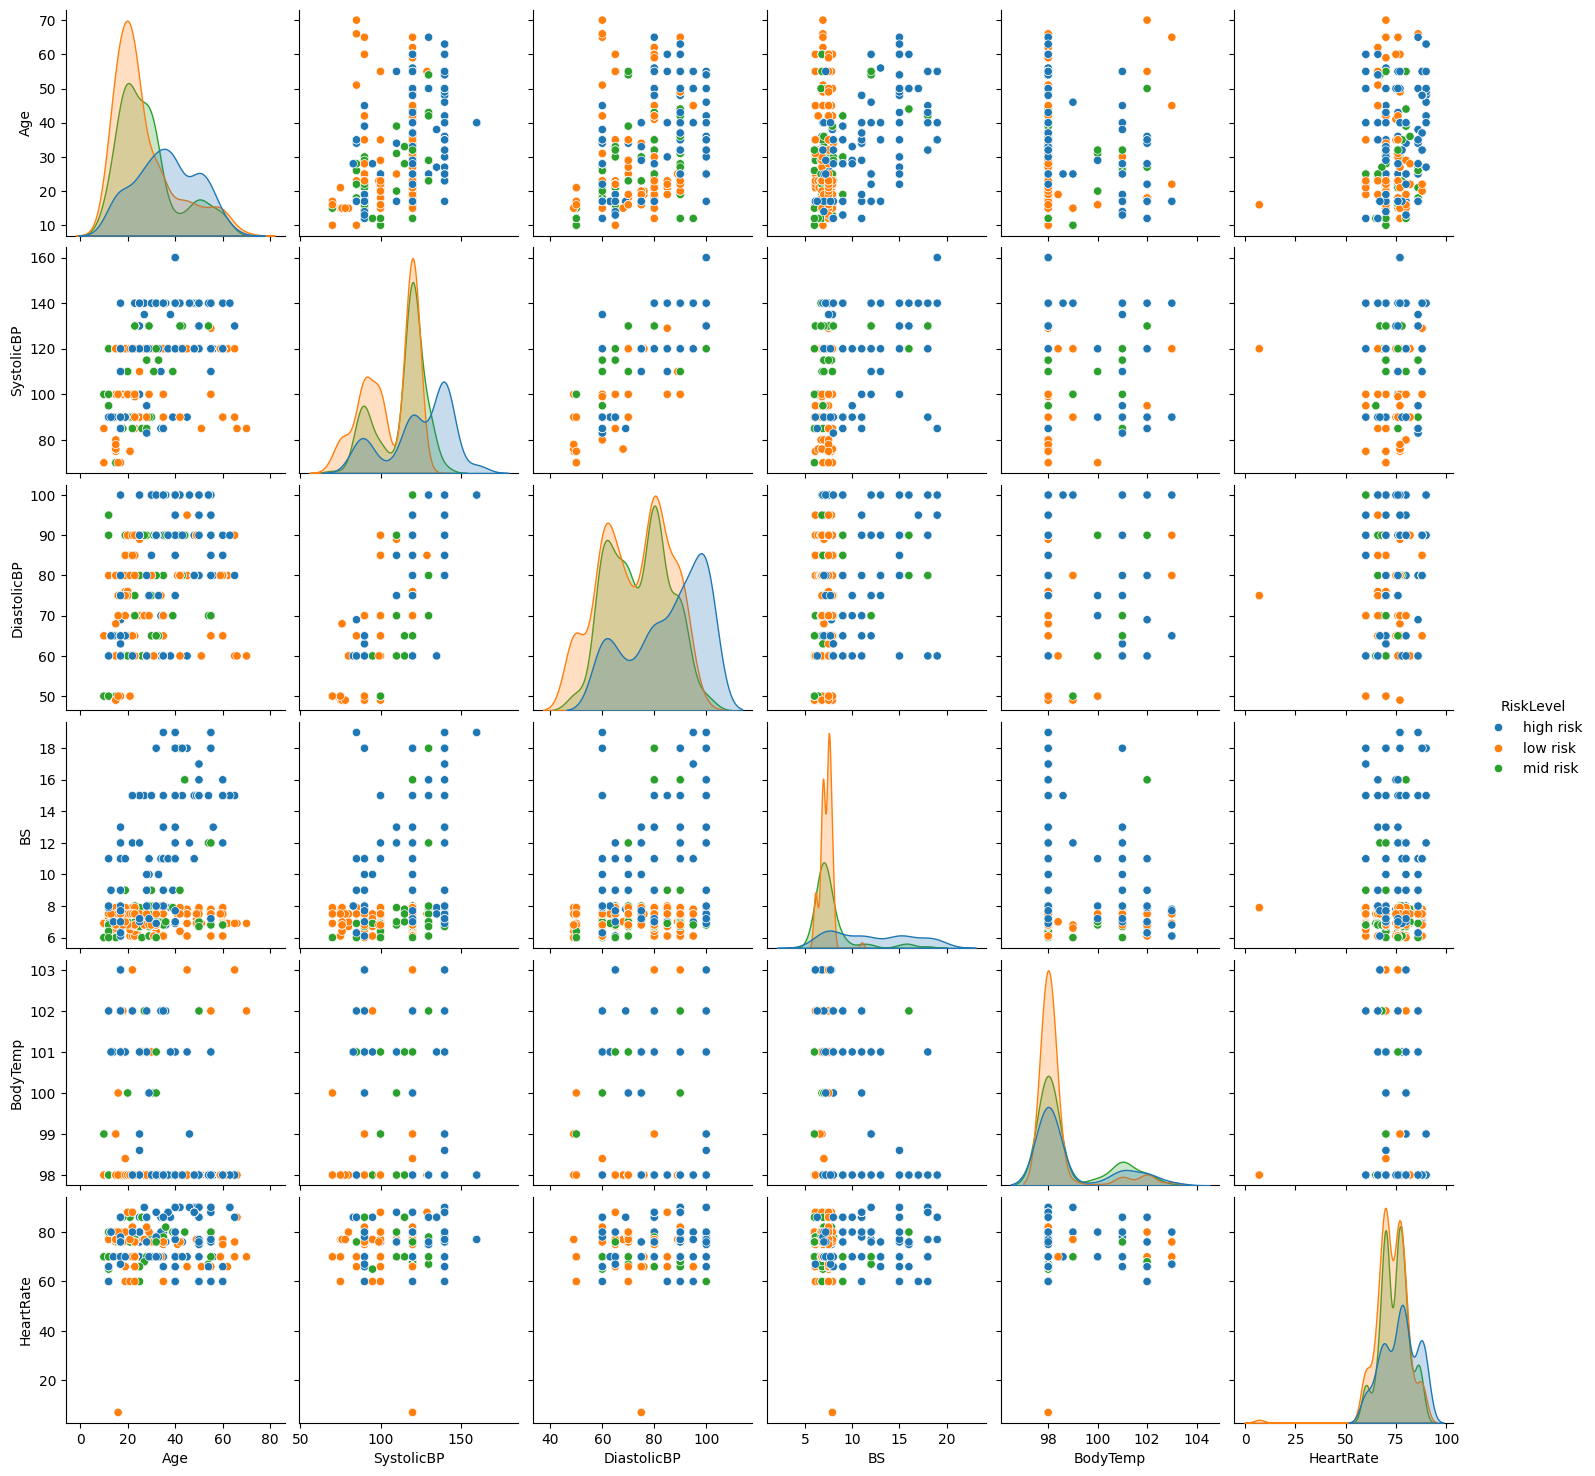

In [5]:
sns.pairplot(data, hue='RiskLevel');

**Вывод:**
* В данных содержится 1014 наблюдений и 6 количественных показателей;
* Ключевой показатель: уровень риска. В данных есть низкий, средний и высокий риск. Т.о., мы будем решать задачу многоклассовой классификации;
* В описании данных отсутствует описание столбца BodyTemp, но предположим, что это температура человека;
* Рекомендуется изменить подписи столбцов;
* В данных отсутствуют пропуски, но содержатся 562 дубликата (при том, что всего в таблице 1014 строк). Дубликаты в таком случае решено не удалять, т.к. наличие дубликатов отражает часто распространенное сочетание параметров;
* Необходимо закодировать риск;
* На распределении показателя BodyTemp видно, что в основном в нем содержатся целочисленные значения, и пара значений с дробным числом. Следовательно, в основном в датасет записывали округленную температуру, но несколько раз указали со знаком после запятой. В жизни температура колеблется, и редко составляет ровное значение, поэтому оставим показатель в типе float;
* Рекомендуется добавить абсолютный или относительный показатель разницы между систолическим и диастолическим давлением, т.к. по отдельности каждое может входить в референсные значения, но при этом разница между ними может быть критичной;
* Можно добавить качественные показатели, которые будут означать клиническую норму для каждого показателя;
* В показателе HeartRate содержится выброс - пульс 7. Скорее всего, это пульс 70, необходимо исправить значение;
* Необходимо дополнительно исследовать показатели на предмет выбросов и прочих неадекватных данных;
* Необходимо разделить выборку на обучающую и тестовую.

## Разделение данных на обучающую и тестовую выборку

Разделим датасет на train и test сразу, чтобы избежать ошибки подглядывания

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=123)
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для train'}\033[0m")
display(train.describe())
print(f"\033[1m{'Распределение целевого показателя для train'}\033[0m")
print(train['RiskLevel'].value_counts(normalize=True))
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для test'}\033[0m")
display(test.describe())
print(f"\033[1m{'Распределение целевого показателя для test'}\033[0m")
print(test['RiskLevel'].value_counts(normalize=True))
print('-----------------------------------------------------------------------')

-----------------------------------------------------------------------
Распределение статистических показателей для train


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,29.574599,112.933416,76.262639,8.659211,98.680641,74.373613
std,13.287246,18.334896,13.764557,3.223935,1.379661,7.908723
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,95.000000,65.000000,6.900000,98.000000,70.000000
50%,25.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,37.500000,120.000000,90.000000,7.950000,98.000000,80.000000
max,66.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Распределение целевого показателя для train
RiskLevel
low risk     0.400740
mid risk     0.337855
high risk    0.261406
Name: proportion, dtype: float64
-----------------------------------------------------------------------
Распределение статистических показателей для test


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,31.059113,114.256158,77.251232,8.992759,98.602956,74.014778
std,14.169290,18.685341,14.367556,3.553941,1.339348,8.785946
min,12.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,28.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,40.000000,120.000000,90.000000,9.000000,98.000000,78.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Распределение целевого показателя для test
RiskLevel
low risk     0.399015
mid risk     0.305419
high risk    0.295567
Name: proportion, dtype: float64
-----------------------------------------------------------------------


**Вывод:** После разделения выборок в train и test немного отличается процентное содержание классов в выборке, но баланс классов относительно друг друга сохранен.

## Исследование данных

### Предобработка обучающей выборки для последующего исследования данных

In [7]:
# Изменение подписей столбцов
train.columns = ['age', 'systolic_bp', 'diastolic_bp', 'b_s',
                 'body_temp', 'heart_rate', 'risk_level']

# Исправление опечаток в heart_rate
train['heart_rate'] = train.apply(lambda row: row['heart_rate']*10
                                              if row['heart_rate'] < 10
                                              else row['heart_rate'],
                                  axis=1)

# Ordinal Encoding для risk_level.
# Можно и через sklearn, просто операция переименования в данном случае не сложная
train['target'] = train.apply(lambda row: 0
                                          if row['risk_level'] == 'low risk'
                                          else (2
                                                if row['risk_level'] == 'high risk'
                                                else 1),
                              axis=1)

# Добавление нового столбца с разницой между систолическим и диастолическим давлением
train['bp_diff'] = train['systolic_bp'] - train['diastolic_bp']

# Добавим интерпретацию референсных значений
train['age_info'] =  train.apply(lambda row: ('>45' if row['age'] > 45 else
                                             ('40-45' if (row['age'] > 40 and row['age'] <= 45) else
                                             ('35-40' if (row['age'] > 35 and row['age'] <= 40) else
                                             ('20-34' if (row['age'] > 20 and row['age'] <= 34) else '<20')))),
                                 axis=1)
train['systolic_info'] = train.apply(lambda row: 'high'
                                                 if row['systolic_bp'] > 140
                                                 else ('low'
                                                       if row['systolic_bp'] < 90
                                                       else 'norm'),
                                     axis=1)
train['diastolic_info'] = train.apply(lambda row: 'high'
                                                  if row['diastolic_bp'] > 90
                                                  else ('low'
                                                        if row['diastolic_bp'] < 60
                                                        else 'norm'),
                                      axis=1)
train['bp_diff_info'] = train.apply(lambda row: 'high'
                                                if row['bp_diff'] > 50
                                                else ('low'
                                                      if row['bp_diff'] < 30
                                                      else 'norm'),
                                    axis=1)
train['b_s_info'] = train.apply(lambda row: 'high'
                                            if row['b_s'] > 6.1
                                            else ('low'
                                                  if row['b_s'] < 4.4
                                                  else 'norm'),
                                axis=1)
train['body_temp_info'] = train.apply(lambda row: 'high'
                                             if row['body_temp'] > 99.5
                                             else ('low'
                                                   if row['body_temp'] < 97.7
                                                   else 'norm'),
                                      axis=1)
train['heart_rate_info'] = train.apply(lambda row: 'high'
                                                   if row['heart_rate'] > 80
                                                   else ('low'
                                                         if row['heart_rate'] < 60
                                                         else 'norm'),
                                       axis=1)

train.head()

,age,systolic_bp,diastolic_bp,b_s,body_temp,heart_rate,risk_level,target,bp_diff,age_info,systolic_info,diastolic_info,bp_diff_info,b_s_info,body_temp_info,heart_rate_info
375,60,120,80,7.8,98.0,75,high risk,2,40,>45,norm,norm,norm,high,norm,norm
841,39,110,70,7.9,98.0,80,mid risk,1,40,35-40,norm,norm,norm,high,norm,norm
803,19,120,80,7.0,98.0,70,mid risk,1,40,<20,norm,norm,norm,high,norm,norm
316,22,120,60,15.0,98.0,80,high risk,2,60,20-34,norm,norm,high,high,norm,norm
527,19,120,80,7.0,98.0,70,low risk,0,40,<20,norm,norm,norm,high,norm,norm


### Исследование баланса уровней рисков в данных

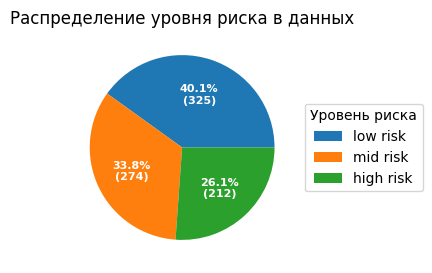

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
risk_data = train['risk_level'].value_counts().reset_index()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges, texts, autotexts = ax.pie(risk_data['count'], autopct=lambda pct: func(pct, risk_data['count']), textprops=dict(color="w"))
ax.legend(wedges, risk_data['risk_level'], title="Уровень риска", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Распределение уровня риска в данных")
plt.show()

**Вывод:** \
Данные не идеально сбалансированы. Большинство в данных составляют женщины с низким уровнем риска, а меньшинство - женщины с высоким уровнем риска. Тем не менее, разница в балансе классов не слишком велика. \
Можно исправить баланс классов на train, но на test данные окажутся несбалансированы, и тогда при тестировании мы можем получить значительное ухудшение метрики. Поэтому, необходимо выбрать метрику, которая будет отражать несбалансированность классов. \
Нам важно, чтобы модель выявляла всех женщин с высоким риском (здесь могла бы пригодиться метрика Recall). Но при этом, меры профилактики и лечения, предназначенные для женщин с высоким уровнем риска, могут ухудшить здоровье женщин с низким и средним уровнем риска, для которых модель ошибочно присвоила высокий уровень риска (в таком случае мы бы обратили внимание на метрику Precision). Чтобы удержать баланс метрик, для оценки качества модели используем метрику F1. \
Построение модели в данном случае должно решать задачу многоклассовой классификации. В данном случае для усреднения оценок F1 решено выбрать f1_macro (f1 вычисляется для каждого класса, и потом вычисляется среднее), так как нам важен каждый из классов. Если бы мы выбрали взвешенную оценку (f1 micro или f1 weighted), то в конечную метрику больший вклад дал бы класс с низким уровнем риска.

### Исследование влияния возраста на риск, связанный с беременностью

-----------------------------------------------------------------------
Распределение статистических показателей для показателя возраста


,count,mean,std,min,0.1%,2.1%,25%,50%,75%,97.9%,99.9%,max
age,811.0,29.574599,13.287246,10.0,10.0,12.0,19.0,25.0,37.5,60.0,65.19,66.0


-----------------------------------------------------------------------


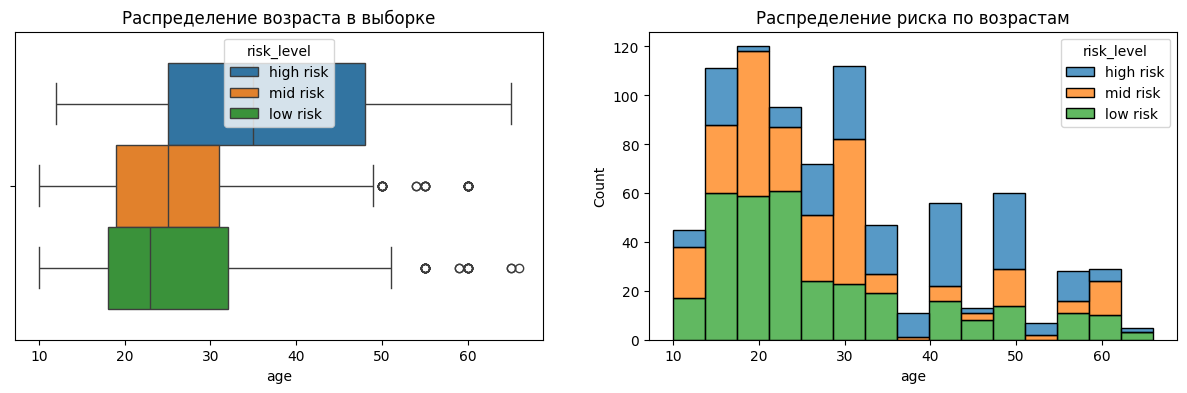

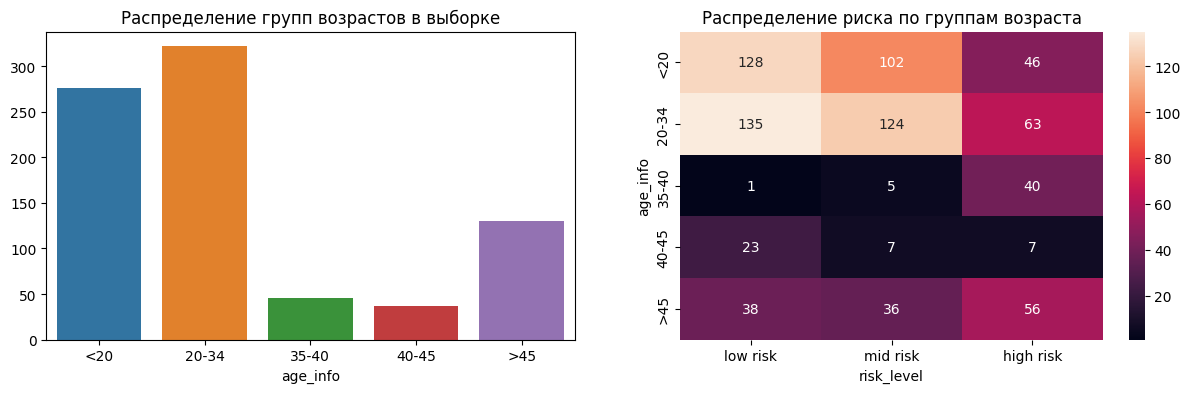

In [9]:
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для показателя возраста'}\033[0m")
display(train[['age']].describe(percentiles=[0.001, 0.021, 0.25, 0.5, 0.75, 0.979, 0.999]).T)
print('-----------------------------------------------------------------------')

fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(train, x='age', hue='risk_level')
plt.title('Распределение возраста в выборке')

ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(train, x='age', hue='risk_level', multiple='stack')
plt.title('Распределение риска по возрастам')

fig = plt.figure(figsize = (15, 4))
ax3 = fig.add_subplot(1, 2, 1)
sns.barplot(train.pivot_table(index='age_info', values='age', aggfunc='count')
                 .reindex(['<20', '20-34', '35-40', '40-45', '>45']).T)
plt.title('Распределение групп возрастов в выборке')

ax4 = fig.add_subplot(1, 2, 2)
age_pivot = (train.pivot_table(index='age_info', columns='risk_level', values='age', aggfunc='count')
             .reindex(['<20', '20-34', '35-40', '40-45', '>45']))
sns.heatmap((age_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Распределение риска по группам возраста');

**Вывод**
* В основном в выборке содержатся данные по женщинам в возрасте от 19 до 38 лет;
* В группы с низким и средним риском в основном входят женщины возраста от 19 до 32, а в группу с высоким риском - женщины от 25 до 48 и выше;
* Группы с возрастом более 35 лет составляют не такую большую величину, и поэтому могут быть подвержены выбросам. Так, например, общепринято, что риск, связанный с беременностью, высок для подростковой беременности и для поздней беременности (от 45). Но, например, почти все женщины из группы 35-40 лет попали в группу высокорисковых, а женщины в возрасте 40-45 лет - в группу с низким риском. Выбросить таких пациентов из данных мы не можем, но деревянные модели будут завышать / занижать риск для данных категорий. Можно было бы сгенерировать недостающие данные, но это было бы искажением клинической картины.

### Исследование влияния артериального давления на риск, связанный с беременностью

-----------------------------------------------------------------------
Распределение статистических показателей для показателя возраста


,count,mean,std,min,0.1%,2.1%,25%,50%,75%,97.9%,99.9%,max
systolic_bp,811.0,112.933416,18.334896,70.0,70.00,76.0,95.0,120.0,120.0,140.0,160.0,160.0
diastolic_bp,811.0,76.262639,13.764557,49.0,49.00,50.0,65.0,80.0,90.0,100.0,100.0,100.0
bp_diff,811.0,36.670777,11.463474,8.0,9.62,15.0,30.0,35.0,40.0,60.0,75.0,75.0


-----------------------------------------------------------------------


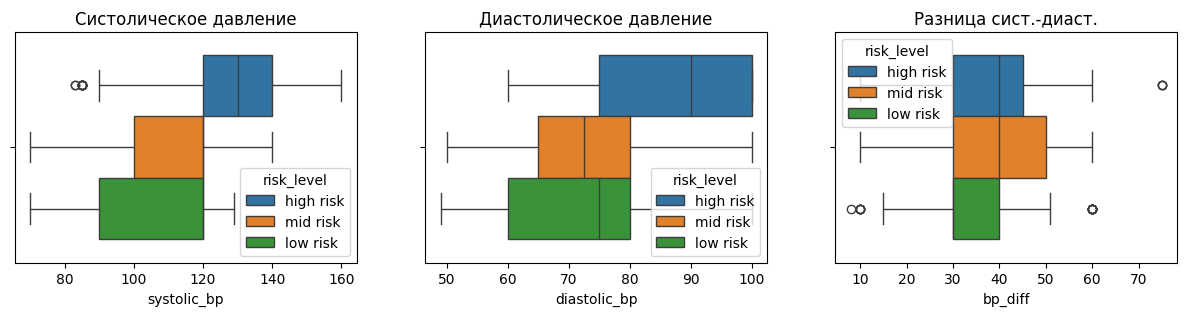

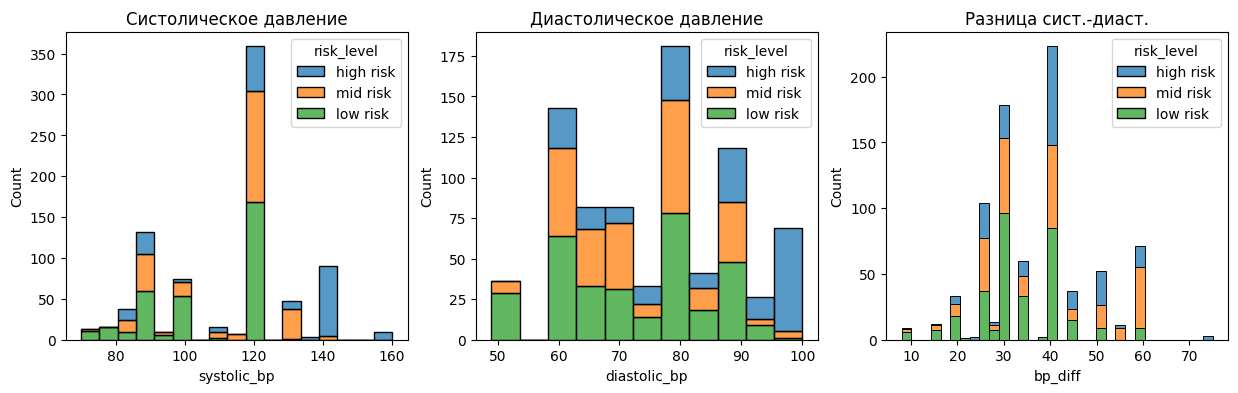

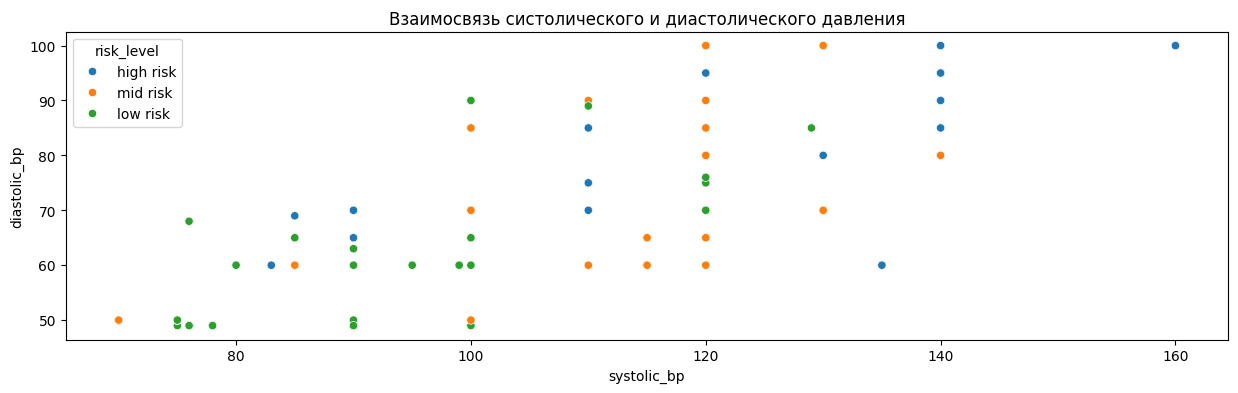

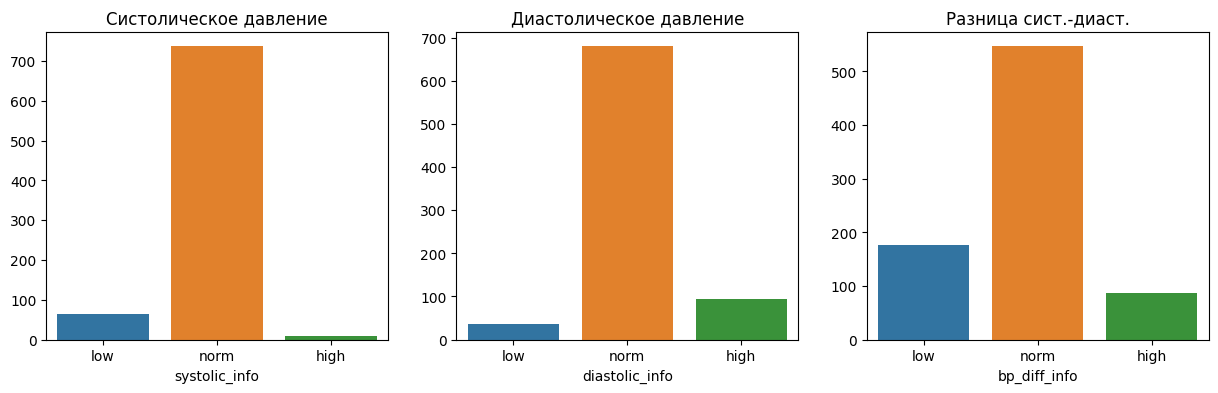

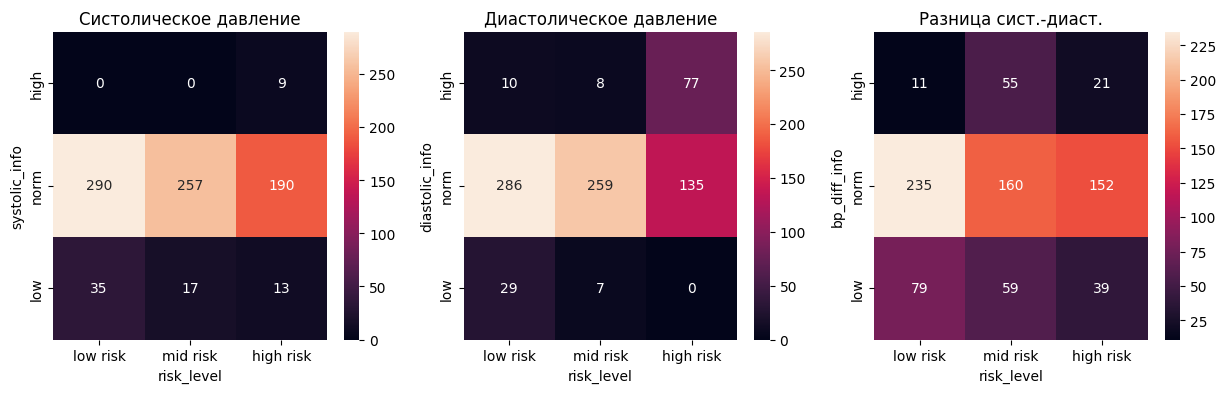

In [10]:
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для показателя возраста'}\033[0m")
display(train[['systolic_bp', 'diastolic_bp', 'bp_diff']]
        .describe(percentiles=[0.001, 0.021, 0.25, 0.5, 0.75, 0.979, 0.999]).T)
print('-----------------------------------------------------------------------')
fig = plt.figure(figsize = (15, 3))
ax1 = fig.add_subplot(1, 3, 1)
sns.boxplot(train, x='systolic_bp', hue='risk_level')
plt.title('Систолическое давление')

ax2 = fig.add_subplot(1, 3, 2)
sns.boxplot(train, x='diastolic_bp', hue='risk_level')
plt.title('Диастолическое давление')

ax3 = fig.add_subplot(1, 3, 3)
sns.boxplot(train, x='bp_diff', hue='risk_level')
plt.title('Разница сист.-диаст.')


fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 3, 1)
sns.histplot(train, x='systolic_bp', hue='risk_level', multiple='stack')
plt.title('Систолическое давление')

ax2 = fig.add_subplot(1, 3, 2)
sns.histplot(train, x='diastolic_bp', hue='risk_level', multiple='stack')
plt.title('Диастолическое давление')

ax3 = fig.add_subplot(1, 3, 3)
sns.histplot(train, x='bp_diff', hue='risk_level', multiple='stack')
plt.title('Разница сист.-диаст.')

fig = plt.figure(figsize=(15, 4))
sns.scatterplot(train, x='systolic_bp', y='diastolic_bp', hue='risk_level');
plt.title('Взаимосвязь систолического и диастолического давления')

fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(train.pivot_table(index='systolic_info', values='systolic_bp', aggfunc='count')
                 .reindex(['low', 'norm', 'high']).T)
plt.title('Систолическое давление')

ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(train.pivot_table(index='diastolic_info', values='diastolic_bp', aggfunc='count')
                 .reindex(['low', 'norm', 'high']).T)
plt.title('Диастолическое давление')

ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(train.pivot_table(index='bp_diff_info', values='bp_diff', aggfunc='count')
                 .reindex(['low', 'norm', 'high']).T)
plt.title('Разница сист.-диаст.')


fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 3, 1)
systolic_pivot = (train.pivot_table(index='systolic_info', columns='risk_level', values='systolic_bp', aggfunc='count', fill_value=0)
                       .reindex(['high', 'norm', 'low']))
sns.heatmap((systolic_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Систолическое давление')

ax2 = fig.add_subplot(1, 3, 2)
diastolic_pivot = (train.pivot_table(index='diastolic_info', columns='risk_level', values='diastolic_bp', aggfunc='count', fill_value=0)
                        .reindex(['high', 'norm', 'low']))
sns.heatmap((diastolic_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Диастолическое давление')

ax3 = fig.add_subplot(1, 3, 3)
bp_diff_pivot = (train.pivot_table(index='bp_diff_info', columns='risk_level', values='bp_diff', aggfunc='count', fill_value=0)
                       .reindex(['high', 'norm', 'low']))
sns.heatmap((bp_diff_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Разница сист.-диаст.');

**Вывод**
* В основном в выборке систолическое давление находится в диапазоне от 95 до 120 (при норме от 90 до 140), а диастолическое - от 65 до 90 (при норме от 60 до 90). Разница между ними находится в основном в диапазоне от 30 до 40 (пр норме от 30 до 50);
* Разница в распределениях показателей давления для разных уровней рисков хорошо видна отдельно для систолического и диастолического давления (группа с высоким уровнем риска при беременности имеет разброс основных значений на более высоких значениях, чем группы с низким и средним риском), но плохо видна для показателя разницы между систолическим и дистолическим давлением. Возможно, это будет не лучший показатель для выявления рисков беременности;
* Из распределений показателей систолического и диастолического давления видно, что низкое давление не сильно влияет на риск, связанный с беременностью. При этом высокое систолическое давление (выше 120) означает высокий или средний риск.

### Исследование влияния уровня сахара в крови на риск, связанный с беременностью

-----------------------------------------------------------------------
Распределение статистических показателей для показателя уровня сахара в крови


,count,mean,std,min,0.1%,2.1%,25%,50%,75%,97.9%,99.9%,max
b_s,811.0,8.659211,3.223935,6.0,6.0,6.0,6.9,7.5,7.95,18.0,19.0,19.0


-----------------------------------------------------------------------


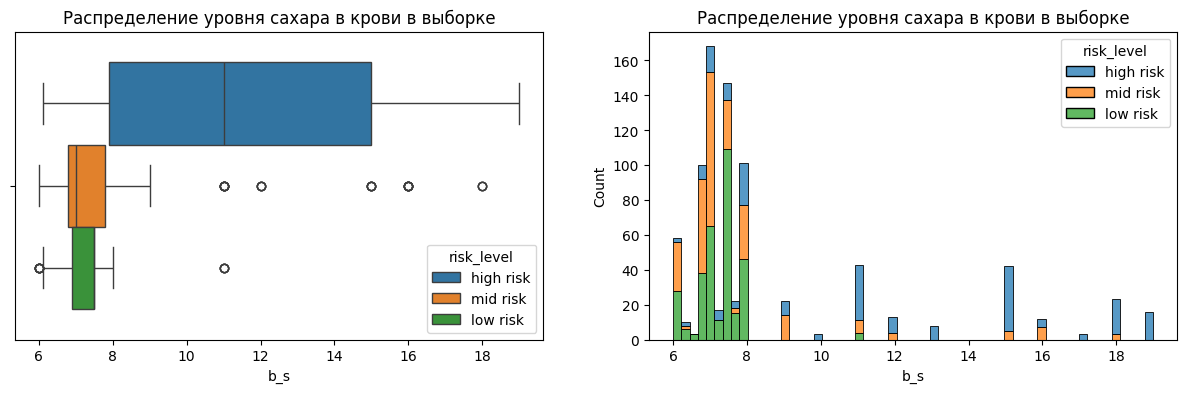

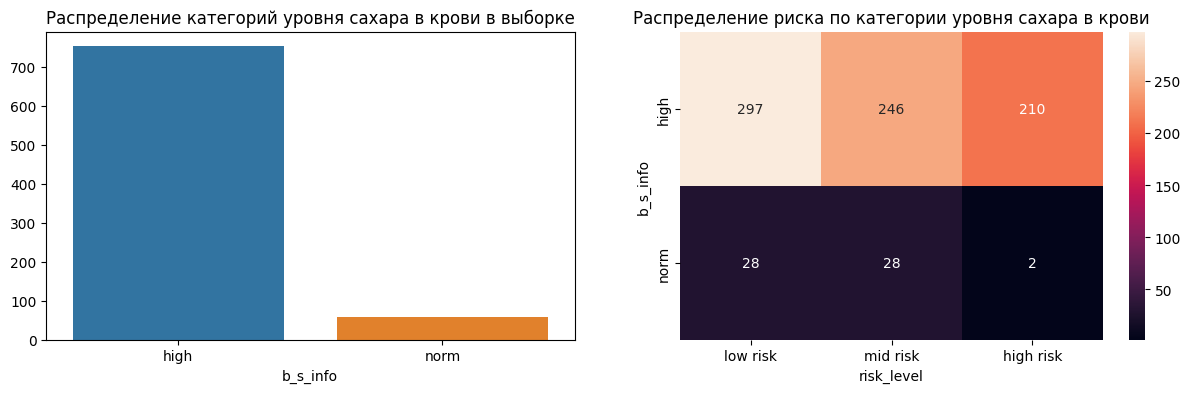

In [11]:
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для показателя уровня сахара в крови'}\033[0m")
display(train[['b_s']].describe(percentiles=[0.001, 0.021, 0.25, 0.5, 0.75, 0.979, 0.999]).T)
print('-----------------------------------------------------------------------')

fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(train, x='b_s', hue='risk_level')
plt.title('Распределение уровня сахара в крови в выборке')

ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(train, x='b_s', hue='risk_level', multiple='stack')
plt.title('Распределение уровня сахара в крови в выборке')

fig = plt.figure(figsize = (15, 4))
ax3 = fig.add_subplot(1, 2, 1)
sns.barplot(train.pivot_table(index='b_s_info', values='b_s', aggfunc='count').T)
plt.title('Распределение категорий уровня сахара в крови в выборке')

ax4 = fig.add_subplot(1, 2, 2)
b_s_pivot = (train.pivot_table(index='b_s_info', columns='risk_level', values='b_s', aggfunc='count'))
sns.heatmap((b_s_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Распределение риска по категории уровня сахара в крови');

**Вывод**
* В описании данных заявлено, что уровень сахара в крови измеряется в ммоль/литр. Существуют разные диапазоны референсных значений, но общепринятой величиной уровня сахара в крови является значение между 4.4 и 6.1. В данных основной диапазон значений лежит в пределах от 6.9 до 7.95 ммоль/литр, что уже является повышенным значением сахара в крови. Из этого можно сделать 2 предположения: либо датасет содержит данные по женщинам-диабетикам, либо в данных допущена ошибка: ошибка измерения, ошибка в формате числа, модификация исходного значения;
* В связи с указанным в предыдущем пункте, показатель b_s_info можно считать бесполезным - необходимо удалить его из выборки;
* Тем не менее, из распределения видно, что для низкого и среднего показателя риска основные значения лежат в диапазоне до 8 ммоль/литр, а показатели для высокого риска - в диапазоне от 8 и выше.

### Исследование влияния температуры тела на риск, связанный с беременностью

-----------------------------------------------------------------------
Распределение статистических показателей для показателя температуры тела


,count,mean,std,min,0.1%,2.1%,25%,50%,75%,97.9%,99.9%,max
body_temp,811.0,98.680641,1.379661,98.0,98.0,98.0,98.0,98.0,98.0,102.0,103.0,103.0


-----------------------------------------------------------------------


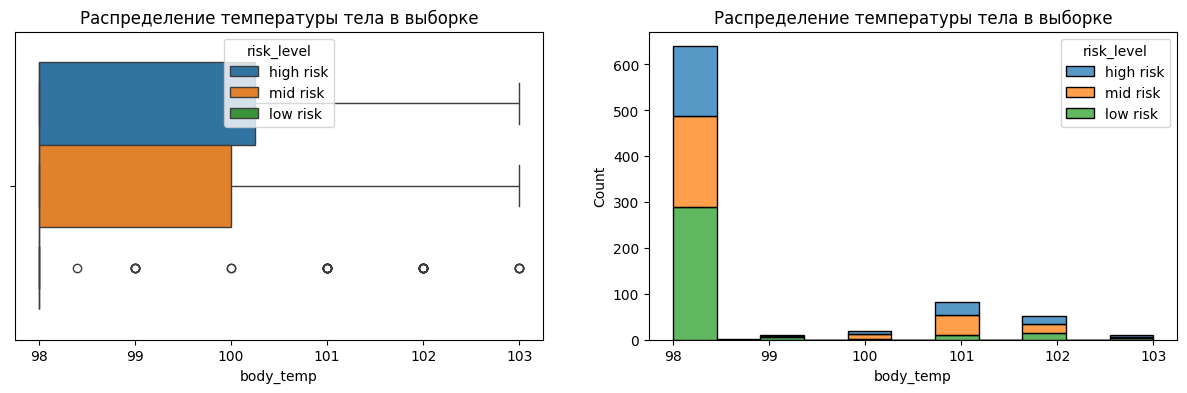

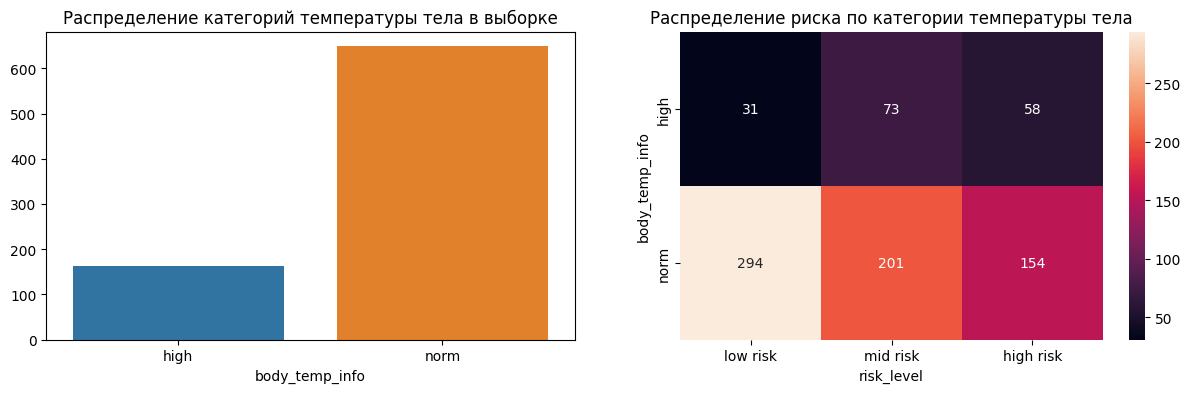

In [12]:
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для показателя температуры тела'}\033[0m")
display(train[['body_temp']].describe(percentiles=[0.001, 0.021, 0.25, 0.5, 0.75, 0.979, 0.999]).T)
print('-----------------------------------------------------------------------')

fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(train, x='body_temp', hue='risk_level')
plt.title('Распределение температуры тела в выборке')

ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(train, x='body_temp', hue='risk_level', multiple='stack')
plt.title('Распределение температуры тела в выборке')

fig = plt.figure(figsize = (15, 4))
ax3 = fig.add_subplot(1, 2, 1)
sns.barplot(train.pivot_table(index='body_temp_info', values='body_temp', aggfunc='count').T)
plt.title('Распределение категорий температуры тела в выборке')

ax4 = fig.add_subplot(1, 2, 2)
b_s_pivot = (train.pivot_table(index='body_temp_info', columns='risk_level', values='body_temp', aggfunc='count'))
sns.heatmap((b_s_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Распределение риска по категории температуры тела');

**Вывод**
* Из распределений видно, что показатель температуры тела не сильно влияет на риск, связанный с беременностью. Но это связано скорее с тем, что в выборке мало строк с повышенной температурой;
* Среди малого количества строк с повышенной температурой все-таки заметно, что при температуре выше 99 риск, связанный с беременностью выше.

### Исследование влияния пульса на риск, связанный с беременностью

-----------------------------------------------------------------------
Распределение статистических показателей для показателя пульса


,count,mean,std,min,0.1%,2.1%,25%,50%,75%,97.9%,99.9%,max
heart_rate,811.0,74.451295,7.547285,60.0,60.0,60.0,70.0,76.0,80.0,88.0,90.0,90.0


-----------------------------------------------------------------------


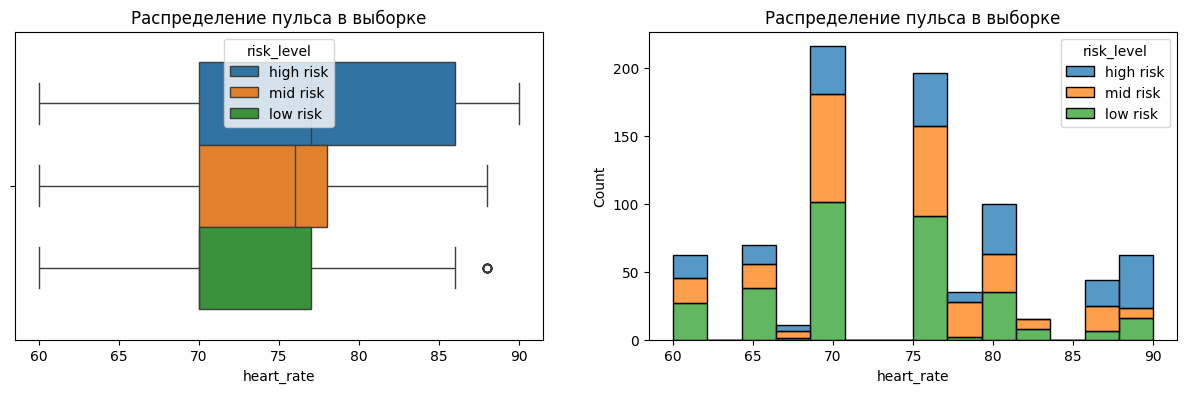

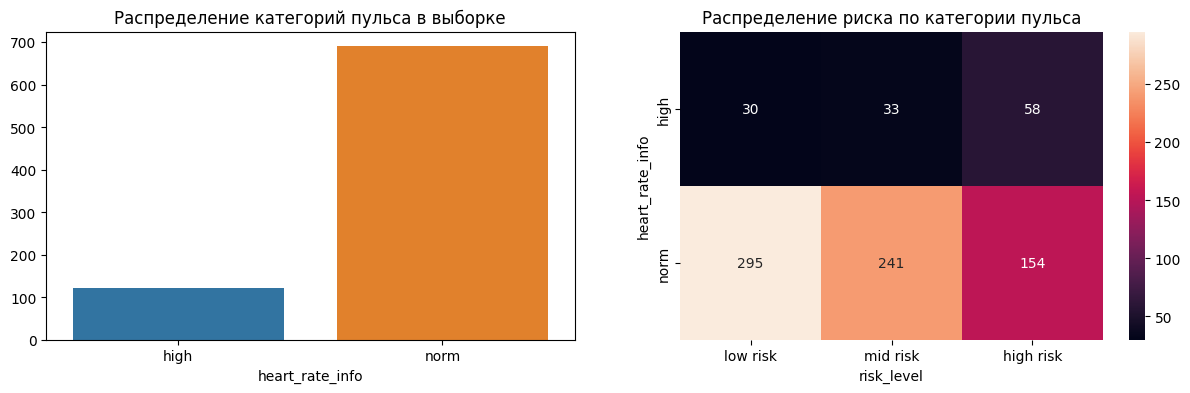

In [13]:
print('-----------------------------------------------------------------------')
print(f"\033[1m{'Распределение статистических показателей для показателя пульса'}\033[0m")
display(train[['heart_rate']].describe(percentiles=[0.001, 0.021, 0.25, 0.5, 0.75, 0.979, 0.999]).T)
print('-----------------------------------------------------------------------')

fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(train, x='heart_rate', hue='risk_level')
plt.title('Распределение пульса в выборке')

ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(train, x='heart_rate', hue='risk_level', multiple='stack')
plt.title('Распределение пульса в выборке')

fig = plt.figure(figsize = (15, 4))
ax3 = fig.add_subplot(1, 2, 1)
sns.barplot(train.pivot_table(index='heart_rate_info', values='heart_rate', aggfunc='count').T)
plt.title('Распределение категорий пульса в выборке')

ax4 = fig.add_subplot(1, 2, 2)
b_s_pivot = (train.pivot_table(index='heart_rate_info', columns='risk_level', values='heart_rate', aggfunc='count'))
sns.heatmap((b_s_pivot[['low risk', 'mid risk', 'high risk']]), annot=True, fmt='d')
plt.title('Распределение риска по категории пульса');

**Вывод**
* Из распределений видно, что чем выше пульс, тем сильнее повышается риск для беременности;
* Тем не менее, наличие нормального пульса еще не означает отсутствия рисков для беременности.

### Исследование взаимосвязи показателей

interval columns not set, guessing: ['age', 'systolic_bp', 'diastolic_bp', 'bp_diff', 'b_s', 'body_temp', 'heart_rate']


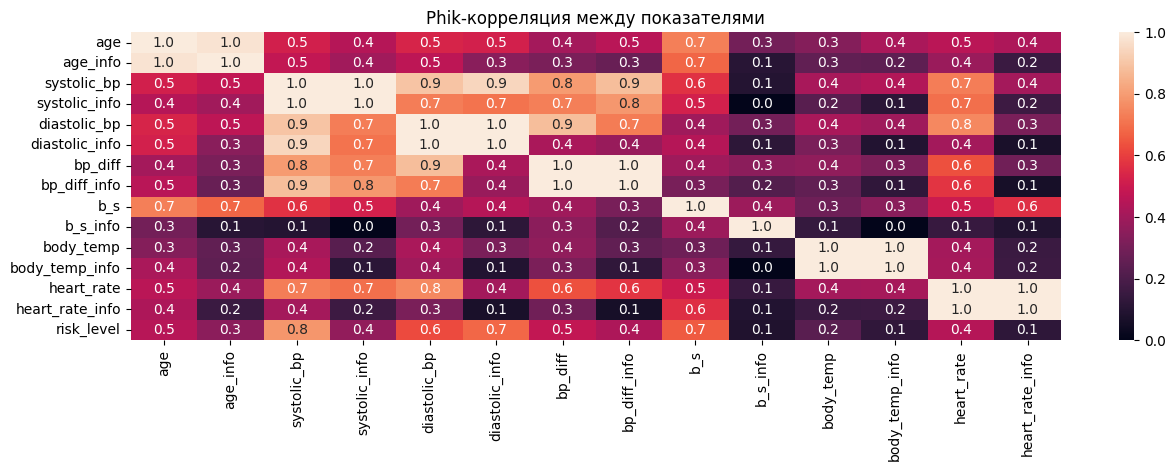

In [14]:
# Рассмотрим phik-корреляцию показателей для выявления мультиколлинеарности и выявления наиболее важных показателей
fig = plt.figure(figsize = (15,4))
sns.heatmap((train[['age', 'age_info', 'systolic_bp', 'systolic_info',
                    'diastolic_bp', 'diastolic_info', 'bp_diff', 'bp_diff_info',
                   'b_s', 'b_s_info', 'body_temp', 'body_temp_info',
                    'heart_rate', 'heart_rate_info', 'risk_level']]
             .phik_matrix()
             [['age', 'age_info', 'systolic_bp', 'systolic_info',
               'diastolic_bp', 'diastolic_info', 'bp_diff', 'bp_diff_info',
               'b_s', 'b_s_info', 'body_temp', 'body_temp_info',
               'heart_rate', 'heart_rate_info']])
             , annot=True, fmt=".01f")
plt.title('Phik-корреляция между показателями');

**Вывод**
* Из phik-корреляций видно, что параметры с интерпретацией показателей хуже коррелируют с показателями риска беременности. Но при этом они сильно коррелируют с теми показателями, которые интерпретируют (что логично), а это значит, что их лучше убрать, чтобы избежать проблемы мультиколлинеарности;
* Сильнее всего на показатель риска влияют показатели систолического давления, уровень сахара в крови, диастолического давления;
* На показатель риска слабее всего влияет высокая температура, но как было ранее выявлено - в данных в целом мало строк с высокой температурой. Т.о., температура не является главным фактором, но может стать одним из дополнительных факторов риска во время беременности;
* Показатели систолического, диастолического давления и разницы между ними сильно коррелируют между собой. Следует исследовать полезность от добавления каждого из признаков в модель. Мультиколлинеарность может привести к ошибкам в сходимости логистической регрессии, но ключевое здесь - может. Возможно, эти параметры могут добавить качества в модель, а с мультиколлинеарностью можно бороться с помощью регуляризациии.

In [15]:
# Выведем интерпретации рисков для каждой возрастной группы

# Столбцы с интерпретаций все равно потом будут удалены, но для создания сводной таблице, приведенной ниже, скорректируем распределения
# Референсные значения приведены в соответствие распределениям низкого риска, связанного с беременностью
train['systolic_info'] = train.apply(lambda row: 'high' if row['systolic_bp'] > 120 else ('low' if row['systolic_bp'] < 90 else 'norm'), axis=1)
train['diastolic_info'] = train.apply(lambda row: 'high' if row['diastolic_bp'] > 80 else ('low' if row['diastolic_bp'] < 60 else 'norm'), axis=1)
train['b_s_info'] = train.apply(lambda row: 'high' if row['b_s'] > 8 else ('low' if row['b_s'] < 4.4 else 'norm'), axis=1)
train['body_temp_info'] = train.apply(lambda row: 'high' if row['body_temp'] > 98 else ('low' if row['body_temp'] < 97.7 else 'norm'), axis=1)
train['heart_rate_info'] = train.apply(lambda row: 'high' if row['heart_rate'] > 80 else ('low' if row['heart_rate'] < 70 else 'norm'), axis=1)

# Сформируем сводную таблицу для каждой категории возраста
pd.set_option('display.max_rows', None)
for age_type in ['<20', '20-34', '35-40', '40-45', '>45']:
    print('----------------------------------------------------------------------------------------------------------------------------------------')
    print(f"\033[1m{'Распределение интерпретаций значений показателей для возрастной группы '+age_type}\033[0m")
    display(train[train['age_info'] == age_type].pivot_table(index=['systolic_info', 'diastolic_info', 'b_s_info',
                                                                    'body_temp_info', 'heart_rate_info', 'age_info'],
                                                             columns='risk_level',
                                                             values='age',
                                                             aggfunc='count',
                                                             fill_value=0)
            .reset_index()
            [['systolic_info', 'diastolic_info', 'b_s_info', 'body_temp_info', 'heart_rate_info', 'high risk', 'mid risk', 'low risk']]
            .sort_values(by=['high risk', 'mid risk', 'low risk'],
                         ascending=False))

----------------------------------------------------------------------------------------------------------------------------------------
Распределение интерпретаций значений показателей для возрастной группы <20


risk_level,systolic_info,diastolic_info,b_s_info,body_temp_info,heart_rate_info,high risk,mid risk,low risk
18,norm,norm,high,high,norm,10,0,0
20,norm,norm,norm,high,low,7,3,6
21,norm,norm,norm,high,norm,6,32,14
2,high,high,norm,norm,low,5,0,0
6,low,norm,high,high,high,4,3,0
8,low,norm,norm,high,high,4,2,5
0,high,high,high,norm,norm,2,0,0
7,low,norm,high,norm,high,2,0,0
17,norm,norm,high,high,low,2,0,0
23,norm,norm,norm,norm,norm,1,34,51


----------------------------------------------------------------------------------------------------------------------------------------
Распределение интерпретаций значений показателей для возрастной группы 20-34


risk_level,systolic_info,diastolic_info,b_s_info,body_temp_info,heart_rate_info,high risk,mid risk,low risk
3,high,high,norm,norm,norm,23,0,0
20,norm,norm,high,norm,norm,7,0,0
23,norm,norm,norm,high,norm,6,8,2
1,high,high,high,norm,high,6,0,0
2,high,high,high,norm,norm,6,0,0
10,low,norm,norm,high,high,2,2,0
19,norm,norm,high,high,norm,2,1,0
0,high,high,high,high,norm,2,0,0
22,norm,norm,norm,high,low,2,0,0
26,norm,norm,norm,norm,norm,1,40,60


----------------------------------------------------------------------------------------------------------------------------------------
Распределение интерпретаций значений показателей для возрастной группы 35-40


risk_level,systolic_info,diastolic_info,b_s_info,body_temp_info,heart_rate_info,high risk,mid risk,low risk
2,high,high,high,norm,norm,11,0,0
7,norm,high,high,norm,norm,7,2,0
5,norm,high,high,norm,high,6,0,0
1,high,high,high,norm,high,3,0,0
6,norm,high,high,norm,low,3,0,0
11,norm,norm,norm,norm,norm,2,1,0
0,high,high,high,high,low,2,0,0
3,high,high,norm,high,norm,2,0,0
4,high,norm,norm,high,high,2,0,0
10,norm,norm,high,norm,norm,2,0,0


----------------------------------------------------------------------------------------------------------------------------------------
Распределение интерпретаций значений показателей для возрастной группы 40-45


risk_level,systolic_info,diastolic_info,b_s_info,body_temp_info,heart_rate_info,high risk,mid risk,low risk
1,high,norm,high,norm,norm,2,3,0
0,high,high,high,norm,high,2,0,0
2,norm,high,high,norm,norm,1,4,0
4,norm,norm,high,high,norm,1,0,0
5,norm,norm,high,norm,norm,1,0,0
7,norm,norm,norm,norm,norm,0,0,15
3,norm,high,norm,norm,low,0,0,7
6,norm,norm,norm,high,norm,0,0,1


----------------------------------------------------------------------------------------------------------------------------------------
Распределение интерпретаций значений показателей для возрастной группы >45


risk_level,systolic_info,diastolic_info,b_s_info,body_temp_info,heart_rate_info,high risk,mid risk,low risk
18,norm,norm,high,norm,high,11,5,4
3,high,high,high,norm,norm,11,3,0
1,high,high,high,norm,high,9,0,0
2,high,high,high,norm,low,8,0,0
12,norm,high,high,norm,low,5,5,0
19,norm,norm,high,norm,norm,4,0,0
6,high,norm,high,norm,high,2,0,0
8,high,norm,norm,high,norm,2,0,0
22,norm,norm,norm,norm,norm,1,10,16
7,high,norm,high,norm,low,1,2,0


**Вывод**\
Основные риски для каждой возрастной группы:
* Для женщин < 20 лет: высокая температура и высокий уровень сахара в крови
* Для женщин от 20 до 45 лет: высокое давление и высокий уровень сахара в крови
* Для женщин от 45 лет: высокий уровень сахара в крови, высокий пульс, высокое давление

Таким образом, видим, что несмотря на низкую общую корреляцию параметра температуры тела с уровнем риска, именно этот показатель является основным риском для беременных женщин до 20 лет.

### Исследование важности показателей для модели логистической регрессии

Исследуем важность показателей только для логистической модели, так как проблема мультиколлинеарности для нее критична. Для алгоритмов, построенных на деревьях решений, данная проблема не стоит так остро.

Будем по очереди добавлять параметры, и следить, как от этого изменяется ключевая метрика

In [16]:
# Здесь мы не будем использовать кросс-валидацию, и поэтому сразу разделим датасет на обучащую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(train[['age', 'systolic_bp', 'diastolic_bp', 'bp_diff', 'b_s', 'body_temp', 'heart_rate']],
                                                      train['target'],
                                                      random_state=123)

# Нормализация признаков
X_train_norm = X_train
X_valid_norm = X_valid
columns = X_train_norm.columns
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_norm)
X_train_norm = pd.DataFrame(X_train_norm, columns=columns)
X_valid_norm = scaler.transform(X_valid_norm)
X_valid_norm = pd.DataFrame(X_valid_norm, columns=columns)

In [17]:
# Корреляция признаков с target
(train[['age', 'systolic_bp', 'diastolic_bp', 'bp_diff', 'b_s', 'body_temp', 'heart_rate', 'target']].phik_matrix()
      [['target']]
      .sort_values(by='target').T)

interval columns not set, guessing: ['age', 'systolic_bp', 'diastolic_bp', 'bp_diff', 'b_s', 'body_temp', 'heart_rate', 'target']


,body_temp,heart_rate,age,bp_diff,diastolic_bp,b_s,systolic_bp,target
target,0.231298,0.447432,0.452606,0.477508,0.624291,0.653903,0.782449,1.0


In [18]:
def determine_feature_importance(columns):
    '''Функция, добавляющая в модель новые показатели в порядке, где они дают наибольший прирост к метрике F1-macro'''
    curr_columns = []
    while len(columns) != 0:
        best_f1 = 0
        best_col = None
        for i in columns:
            basic_log_model = OneVsRestClassifier(LogisticRegression(random_state=123))
            basic_log_model.fit(X_train_norm[curr_columns+[i]], y_train)
            pred = basic_log_model.predict(X_valid_norm[curr_columns+[i]])
            f1 = f1_score(y_valid, pred, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_col = i
            print("F1 macro parameter "+i+":", f1)
        columns.remove(best_col)
        curr_columns.append(best_col)
        print("Best parameter: "+best_col+". Current columns:", curr_columns, 'Current F1:', best_f1)
        print()

In [19]:
# Столбцы указаны в порядке убывания коэффициента корреляции с target. Сначала посмотрим все столбцы, потом к столбцу с лучшей метрикой
# прибавим еще один, и так далее
columns = ['systolic_bp', 'b_s', 'diastolic_bp', 'bp_diff', 'age', 'heart_rate', 'body_temp']
determine_feature_importance(columns)

F1 macro parameter systolic_bp: 0.5093598338747457
F1 macro parameter b_s: 0.49151898810711453
F1 macro parameter diastolic_bp: 0.3472309299895507
F1 macro parameter bp_diff: 0.2789247311827957
F1 macro parameter age: 0.3003163386878107
F1 macro parameter heart_rate: 0.2825101407778573
F1 macro parameter body_temp: 0.32610842559384584
Best parameter: systolic_bp. Current columns: ['systolic_bp'] Current F1: 0.5093598338747457

F1 macro parameter b_s: 0.515383296727859
F1 macro parameter diastolic_bp: 0.5307557145696681
F1 macro parameter bp_diff: 0.5307557145696681
F1 macro parameter age: 0.48138217118908627
F1 macro parameter heart_rate: 0.48107939650589376
F1 macro parameter body_temp: 0.4812102773705809
Best parameter: diastolic_bp. Current columns: ['systolic_bp', 'diastolic_bp'] Current F1: 0.5307557145696681

F1 macro parameter b_s: 0.5544140880253439
F1 macro parameter bp_diff: 0.5307557145696681
F1 macro parameter age: 0.5338793338793338
F1 macro parameter heart_rate: 0.5343931

**Вывод:**
* ['systolic_bp']: На первом шаге самым полезным оказался показатель систолического давления;
* ['systolic_bp', 'diastolic_bp']: На втором шаге самым полезным оказался показатель диастолического давления (который коррелирует с систолическим). Следовательно, показатель добавляет какую-то долю новой информации в модель. Параметр 'bp_diff' имеет такую же метрику, что и 'diastolic_bp'. Также метрику мог бы повысить и показатель 'b_s', а все остальные показатели ухудшили бы метрику;
* ['systolic_bp', 'diastolic_bp', 'b_s']: На третьем шаге самым полезным оказался показатель уровня сахара в крови. Также предыдущую метрику могли бы повысить и показатели 'age' и ' heart_rate'. Показатель 'bp_diff' оставил метрику без изменений (т.к. сильно коррелирует с уже использованными 'systolic_bp', 'diastolic_bp'). Показатель 'body_temp' ухудшал метрику;
* ['systolic_bp', 'diastolic_bp', 'b_s', 'age']: На четвертом шаге самым полезным оказался показатель возраста. Показатель 'body_temp' также повышал метрику, а показатели 'bp_diff' и 'heart_rate' ее уменьшали;
* ['systolic_bp', 'diastolic_bp', 'b_s', 'age', 'bp_diff'] На пятом этапе был добавлен параметр 'bp_diff', но видно, что какие-либо изменения F1 macro отсутствуют. Т.е., параметр 'bp_diff' не оказал никакого влияния. Из этого можно сделать вывод, что при наличии параметров 'systolic_bp' и 'diastolic_bp' показатель 'bp_diff' бесполезен, и его можно исключить из данных;
* ['systolic_bp', 'diastolic_bp', 'b_s', 'age', 'bp_diff', 'heart_rate']: На шестом этапе дополнительное включение в модель показателя 'heart_rate' ухудшило модель.
* ['systolic_bp', 'diastolic_bp', 'b_s', 'age', 'bp_diff', 'heart_rate', 'body_temp']: На последнем этаппосле включения 'body_temp', качество модели ухудшилось еще сильнее.

Таким образом, по результатам исследования важности параметров, выявлено, что:
* Сочетание параметров ['systolic_bp', 'diastolic_bp', 'b_s', 'age'] показало наилучшую метрику 0.59;
* Использование показателя 'bp_diff' не оказывает никакого влияния на модель, и его можно исключить.

In [20]:
# Проведем тоже самое, только уберем из перечня столбцов параметры 'diastolic_bp' и 'bp_diff', которые коррелируют с 'systolic_bp'
columns = ['systolic_bp', 'b_s', 'age', 'heart_rate', 'body_temp']
determine_feature_importance(columns)

F1 macro parameter systolic_bp: 0.5093598338747457
F1 macro parameter b_s: 0.49151898810711453
F1 macro parameter age: 0.3003163386878107
F1 macro parameter heart_rate: 0.2825101407778573
F1 macro parameter body_temp: 0.32610842559384584
Best parameter: systolic_bp. Current columns: ['systolic_bp'] Current F1: 0.5093598338747457

F1 macro parameter b_s: 0.515383296727859
F1 macro parameter age: 0.48138217118908627
F1 macro parameter heart_rate: 0.48107939650589376
F1 macro parameter body_temp: 0.4812102773705809
Best parameter: b_s. Current columns: ['systolic_bp', 'b_s'] Current F1: 0.515383296727859

F1 macro parameter age: 0.5749570003439973
F1 macro parameter heart_rate: 0.4993026838892248
F1 macro parameter body_temp: 0.5696826163139165
Best parameter: age. Current columns: ['systolic_bp', 'b_s', 'age'] Current F1: 0.5749570003439973

F1 macro parameter heart_rate: 0.5497277676950998
F1 macro parameter body_temp: 0.5731967409537503
Best parameter: body_temp. Current columns: ['sys

**Вывод:**
* ['systolic_bp']: На первом шаге самым полезным оказался показатель систолического давления;
* ['systolic_bp', 'b_s']: На втором шаге самым полезным оказался показатель уровня сахара в крови. Все остальные показатели ухудшали метрику;
* ['systolic_bp', 'b_s', 'age']: На третьем шаге самым полезным оказался показатель возраста. Показатель 'body_temp' также повышал метрику, а показатель 'heart_rate' ее уменьшал;
* ['systolic_bp', 'b_s', 'age', 'body_temp'] На четвертом этапе был добавлен параметр 'body_temp', который ненамного снизил метрику, но показатель 'heart_rate' снизил бы ее еще сильнее;
* ['systolic_bp', 'b_s', 'age', 'body_temp', 'heart_rate']: На последнем этапе, после включения 'heart_rate', итоговая метрика ухудшилась еще сильнее.

Таким образом, по результатам исследования важности параметров, выявлено, что:
* Сочетание параметров ['systolic_bp', 'b_s', 'age'] показало наилучшую метрику 0.57, но это ниже, чем при использовании в модели 'diastolic_bp'. Таким образом, показатель 'diastolic_bp' стоит оставить в модели.

In [21]:
def draw_feature_importance(columns):
    '''Функция, создающая график для важности показателей логистической регрессии'''
    basic_log_model = OneVsRestClassifier(LogisticRegression(random_state=123))
    basic_log_model.fit(X_train_norm[columns], y_train)
    pred = basic_log_model.predict(X_valid_norm[columns])
    f1 = f1_score(y_valid, pred, average='macro')

    # График важности показателей
    fig = plt.figure(figsize=(15, 6), layout='tight')
    plt.suptitle("Диаграмма важности показателей в модели логистической регрессии с параметрами " + str(columns))

    ax1 = fig.add_subplot(1, 3, 1)
    log_model_coef = pd.DataFrame(data=basic_log_model.estimators_[0].coef_[0], columns=['coef'])
    columns = pd.DataFrame(data=columns, columns=['columns'])
    coef_table = columns.join(log_model_coef)
    diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
    plt.ylabel('Наименование признака')
    plt.xlabel('Коэффициент')
    plt.title('Низкий риск')

    ax2 = fig.add_subplot(1, 3, 2)
    log_model_coef = pd.DataFrame(data=basic_log_model.estimators_[1].coef_[0], columns=['coef'])
    columns = pd.DataFrame(data=columns, columns=['columns'])
    coef_table = columns.join(log_model_coef)
    diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
    plt.ylabel('Наименование признака')
    plt.xlabel('Коэффициент')
    plt.title('Средний риск')

    ax3 = fig.add_subplot(1, 3, 3)
    log_model_coef = pd.DataFrame(data=basic_log_model.estimators_[2].coef_[0], columns=['coef'])
    columns = pd.DataFrame(data=columns, columns=['columns'])
    coef_table = columns.join(log_model_coef)
    diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
    plt.ylabel('Наименование признака')
    plt.xlabel('Коэффициент')
    plt.title('Высокий риск')
    ;

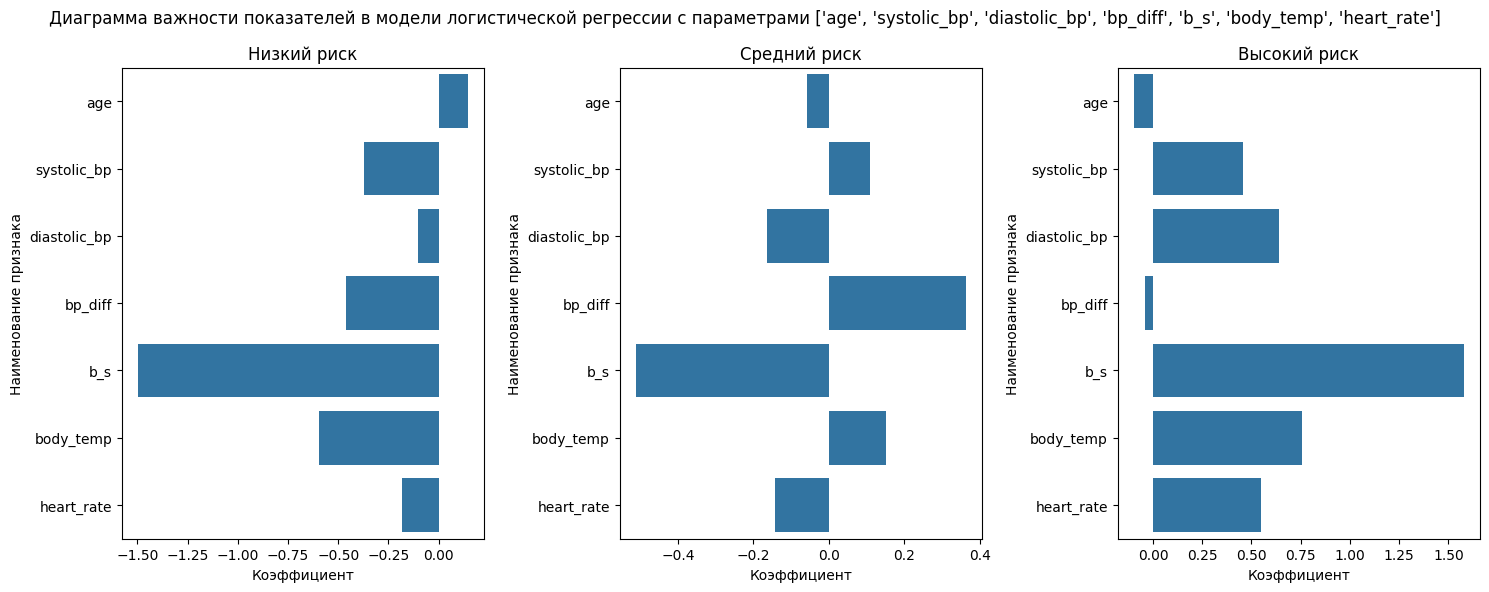

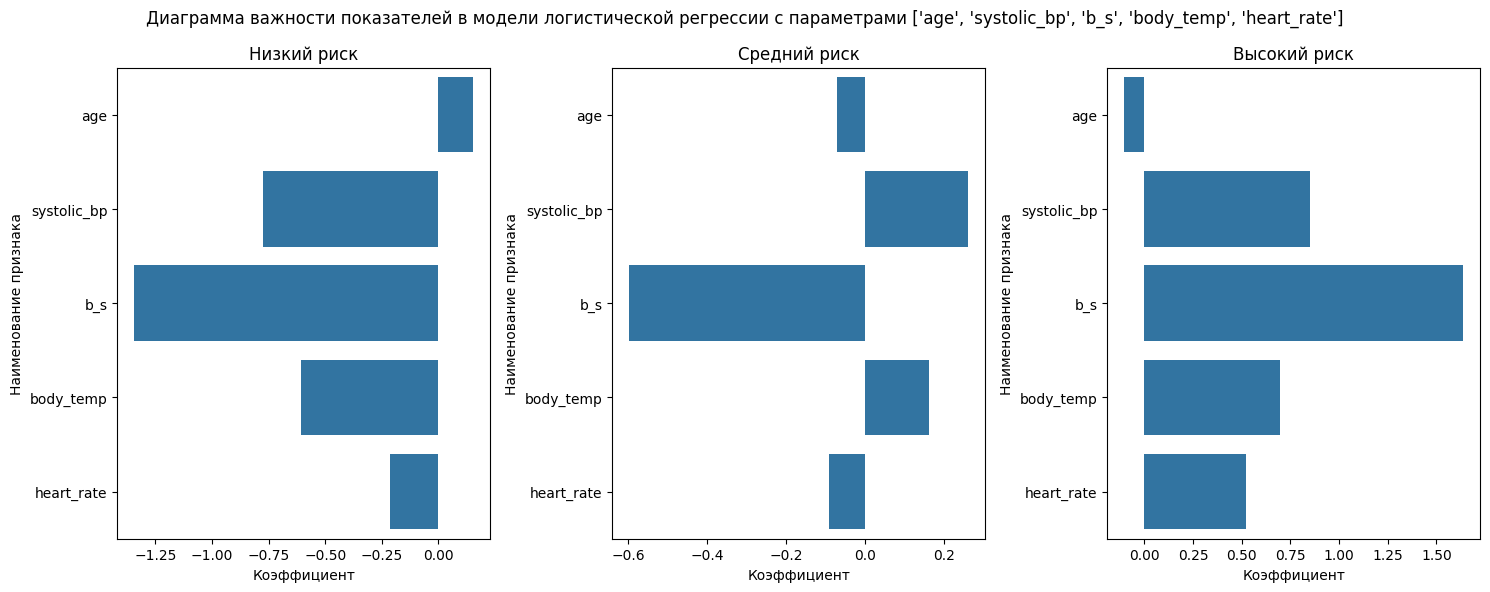

In [22]:
# Сначала выведем график для всех показателей, а потом, для оценки артериального давления на риск оставим только систолическое давление
draw_feature_importance(['age', 'systolic_bp', 'diastolic_bp', 'bp_diff', 'b_s', 'body_temp', 'heart_rate'])
draw_feature_importance(['age', 'systolic_bp', 'b_s', 'body_temp', 'heart_rate'])

**Вывод:**
* На втором ряду графиков лучше видна важность артериального давления в оценке риска, связанного с беременностью. В первом ряду за показатель давления отвечают сразу три показателя, поэтому общая важность показателя делится между ними и становится менее наглядной;
* На каждую модель показатели влияли по-разному: например, для низкого риска показатель уровень сахара в крови взят с отрицательным знаком (следовательно, чем он выше, тем сильнее уменьшается вероятность класса "низкий риск"), а для высокого риска - наоборот, показатель взят с положительным знаком (т.е., чем он выше, тем выше вероятность "высокого риска");
* При этом, если оценивать показатели важности по-модулю, то порядок важности для всех моделей оказался одинаков: самый важный показатель - уровень сахара в крови, потом - систолическое давление, потом температура тела, потом пульс, и потом возраст;
* Возраст оказался наименее важным параметром. Можно предположить, что сам по себе возраст не сильно влияет на риск, связанный с беременностью. Но на этот риск влияют накопленные к моменту беременности хронические заболевания, количество которых среди женщин с возрастом увеличивается. Таким образом, если основной риск "закодирован" в уровне сахара к крови, давлении, пульсе и температуре, то все прочие риски, связанные с возрастом, уже не имеют большого значения.

**Общий вывод по результатам исследования данных:**
* В данных есть дисбаланс классов. Чтобы каждый класс в равной степени вносил свой вклад в итоговую метрику, целевой метрикой выбрана метрика F1-macro;
* В основном в выборке содержатся данные по женщинам в возрасте от 19 до 38 лет. В группы с низким и средним риском в основном входят женщины возраста от 19 до 32, а в группу с высоким риском - женщины от 25 до 48 и выше. Группа с возрастом более 35 лет составляют не такую большую величину, и поэтому может быть подвержена выбросам.
* В основном в выборке систолическое давление находится в диапазоне от 95 до 120 (при норме от 90 до 140), а диастолическое - от 65 до 90 (при норме от 60 до 90). Разница между ними находится в основном в диапазоне от 30 до 40 (пр норме от 30 до 50). Из распределений показателей систолического и диастолического давления видно, что низкое давление не сильно влияет на риск, связанный с беременностью. При этом высокое систолическое давление (выше 120) означает высокий или средний риск.
* В данных по уровню сахара в крови основной диапазон значений лежит в пределах от 6.9 до 7.95 ммоль/литр, что странно, так как общепринятой величиной уровня сахара в крови является значение между 4.4 и 6.1. Тем не менее, из распределения видно, что для низкого и среднего показателя риска основные значения лежат в диапазоне до 8 ммоль/литр, а показатели для высокого риска - в диапазоне от 8 и выше.
* Показатель температуры тела не сильно влияет на риск, связанный с беременностью. Но это связано скорее с тем, что в выборке мало строк с повышенной температурой. Тем не менее, при температуре выше 99 риск, связанный с беременностью, выше.
* Чем выше пульс, тем сильнее повышается риск для беременности. При этом, наличие нормального пульса еще не означает отсутствия рисков для беременности.
* Сильнее всего на показатель риска влияют показатели систолического давления, уровень сахара в крови, диастолического давления. Слабее всего - высокая температура;
* Показатели систолического, диастолического давления сильно коррелируют между собой;
* Выявлено, что основные риски при беременности для женщин < 20 лет составляют высокая температура и высокий уровень сахара в крови. Для женщин от 20 до 45 лет: высокое давление и высокий уровень сахара в крови. Для женщин от 45 лет: высокий уровень сахара в крови, высокий пульс, высокое давление.

## Предобработка данных

Перед проведением исследования было проведено:
* Переименование столбцов;
* Исправление опечаток в heart_rate;
* Ordinal Encoding для risk_level;
* Добавлен новый столбец с разницей между систолическим и диастолическим давлением;
* Добавлены столбцы с интерпретацией значений возраста, систолического давления, диастолического давления, разницы между ними, уровня сахара в крови, температуры тела, пульса;
* Нормализация данных.

По результатам исследования взаимосвязи параметров было выявлено, что столбцы с интерпретацией сильно коррелируют с исходными данными, поэтому от их дальнейшего использования необходимо отказаться. При исследовании важности параметров на примере логистической регрессии было выявлено, что столбец с разницей между систолическим и диастолическим давлением не добавляет качества будущей модели. Поэтому, от показателя решено отказаться.

Ниже, для удобства, приведена вся предобработка обучающей выборки, начиная с ее загрузки. Также проведена предобработка тестовой выборки

In [23]:
# Загрузка данных
data = pd.read_csv("Maternal Health Risk Data Set.csv")

# Разделение датасета на train и test
train, test = train_test_split(data, test_size=0.2, random_state=123)

# Изменение подписей столбцов
train.columns = ['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate', 'risk_level']
test.columns = ['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate', 'risk_level']

# Исправление опечаток в heart_rate
train['heart_rate'] = train.apply(lambda row: row['heart_rate']*10 if row['heart_rate'] < 10 else row['heart_rate'], axis=1)
test['heart_rate'] = test.apply(lambda row: row['heart_rate']*10 if row['heart_rate'] < 10 else row['heart_rate'], axis=1)

# Ordinal Encoding для risk_level. Можно и через sklearn, просто операция переименования в данном случае не сложная
train['target'] = train.apply(lambda row: 0 if row['risk_level'] == 'low risk' else (2 if row['risk_level'] == 'high risk' else 1), axis=1)
test['target'] = test.apply(lambda row: 0 if row['risk_level'] == 'low risk' else (2 if row['risk_level'] == 'high risk' else 1), axis=1)

# Нормализация данных
X_train = train[['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate']]
y_train = train['target']
X_test = train[['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate']]
y_test = train['target']

columns = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns)

## Обучение моделей

Обучим 4 модели:
* Логистическая регрессия
* KNN
* Случайный лес
* Градиентный бустинг (CatBoost)

Как уже ранее было определено, ключевой метрикой будет f1 macro

### Логистическая регрессия

Логистическая модель - базовая модель для решения задач классификации. При выборе параметров логистической регрессии учтем результат исследования важности параметров. Таким образом, будут подобраны три модели логистической регрессии, из которых будет выбрана лучшая:
1. Модель логистической регрессии, построенная на всех параметрах ['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate']
2. Модель логистической регрессии, построенная на всех параметрах, кроме 'diastolic_bp', т.к. этот гиперпараметр сильно коррелирует с параметром 'systolic_bp'
3. Модель логистической регрессии, построенная на параметрах, сочетание которых дало налучшую метрику при исследовании важности параметров  ['systolic_bp', 'diastolic_bp', 'b_s', 'age']

In [24]:
columns_list = [['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate'],
                ['age', 'systolic_bp', 'b_s', 'body_temp', 'heart_rate'],
                 ['systolic_bp', 'diastolic_bp', 'b_s', 'age']]

best_log_model_f1 = 0
best_log_model = None
best_columns = None
best_params = None

for columns in columns_list:

    log_model = OneVsRestClassifier(LogisticRegression())
    param_grid = {'estimator__solver':['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
                  'estimator__penalty':[None, 'l1', 'l2'],
                  'estimator__C':[0.01, 0.1, 1., 10., 100.],
                  'estimator__class_weight':[None, 'balanced'],
                  'estimator__random_state':[123],
                  'estimator__max_iter':[100, 1000]}

    log_model_grid = GridSearchCV(estimator=log_model, param_grid=param_grid, cv=5, scoring='f1_macro')
    log_model_grid.fit(X_train[columns], y_train)
    f1 = log_model_grid.best_score_
    print("Модель логистической регрессии для параметров:", columns)
    print("Лучший F1 macro:", f1)
    print("Лучшее сочетание гиперпараметров:", log_model_grid.best_params_)

    if f1 > best_log_model_f1:
        best_log_model_f1 = f1
        best_log_model = log_model_grid.best_estimator_
        best_columns = columns
        best_params = log_model_grid.best_params_

    print()

print("Лучшая модель логистической регрессии была получена для параметров:", best_columns, ", при гиперпараметрах:", best_params)
print("Лучший F1 macro:", best_log_model_f1)

Модель логистической регрессии для параметров: ['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate']
Лучший F1 macro: 0.6259114807383278
Лучшее сочетание гиперпараметров: {'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'lbfgs'}

Модель логистической регрессии для параметров: ['age', 'systolic_bp', 'b_s', 'body_temp', 'heart_rate']
Лучший F1 macro: 0.6030715397861168
Лучшее сочетание гиперпараметров: {'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'liblinear'}

Модель логистической регрессии для параметров: ['systolic_bp', 'diastolic_bp', 'b_s', 'age']
Лучший F1 macro: 0.6179514883844928
Лучшее сочетание гиперпараметров: {'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__max_iter': 100, 'estimator__penalt

''

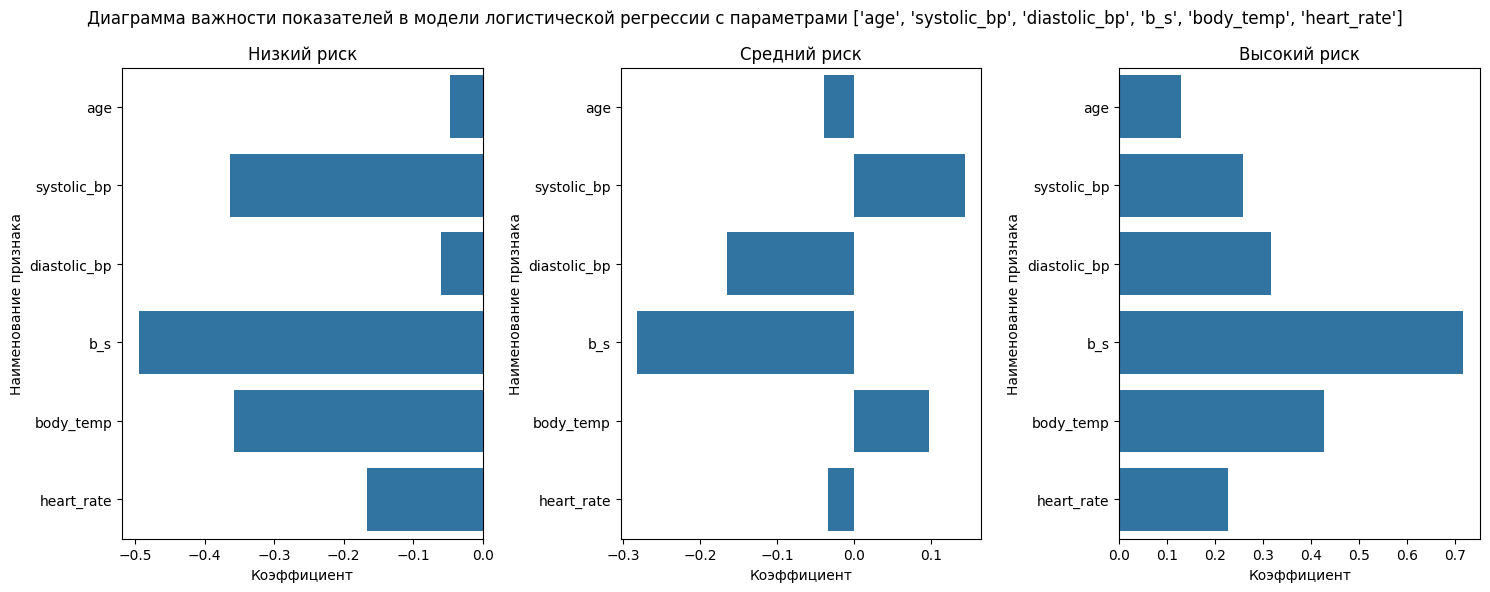

In [25]:
# График важности показателей
fig = plt.figure(figsize=(15, 6), layout='tight')
plt.suptitle("Диаграмма важности показателей в модели логистической регрессии с параметрами " + str(best_columns))

ax1 = fig.add_subplot(1, 3, 1)
log_model_coef = pd.DataFrame(data=best_log_model.estimators_[0].coef_[0], columns=['coef'])
columns = pd.DataFrame(data=best_columns, columns=['columns'])
coef_table = columns.join(log_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title('Низкий риск')

ax2 = fig.add_subplot(1, 3, 2)
log_model_coef = pd.DataFrame(data=best_log_model.estimators_[1].coef_[0], columns=['coef'])
columns = pd.DataFrame(data=best_columns, columns=['columns'])
coef_table = columns.join(log_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title('Средний риск')

ax3 = fig.add_subplot(1, 3, 3)
log_model_coef = pd.DataFrame(data=best_log_model.estimators_[2].coef_[0], columns=['coef'])
columns = pd.DataFrame(data=best_columns, columns=['columns'])
coef_table = columns.join(log_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title('Высокий риск')
;

**Вывод:** \
Лучший F1 для модели логистической регрессии равен 0.626. Данная модель была построена на всех исходных параметрах. Удаление коррелирующего с систолическим давлением параметра диастолического давления привело к ухудшению качества модели до 0.603. Сочетание параметров, подобранное на этапе исследования важности признаков, показало самый худший результат - 0.571. \
Таким образом, лучшей моделью логистической регрессии с F1-macro=0.641 оказалась модель, построенная на параметрах ['age', 'systolic_bp', 'diastolic_bp', 'b_s', 'body_temp', 'heart_rate'] и гиперпараметрах
{'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'lbfgs'}.

### К-ближайших соседей (KNN)

In [26]:
knn_model = OneVsRestClassifier(KNeighborsClassifier())
param_grid = {'estimator__n_neighbors':[1, 2, 3, 5, 7, 10],
              'estimator__weights':['uniform', 'distance'],
              'estimator__p':[1, 2, 3],
              'estimator__n_jobs':[-1]}

knn_model_grid = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='f1_macro')
knn_model_grid.fit(X_train, y_train)
print("Лучший F1 macro:", knn_model_grid.best_score_)
print("Лучшее сочетание гиперпараметров:", knn_model_grid.best_params_)

Лучший F1 macro: 0.8151130784681836
Лучшее сочетание гиперпараметров: {'estimator__n_jobs': -1, 'estimator__n_neighbors': 2, 'estimator__p': 2, 'estimator__weights': 'distance'}


ExactExplainer explainer: 812it [00:25, 20.88it/s]                         


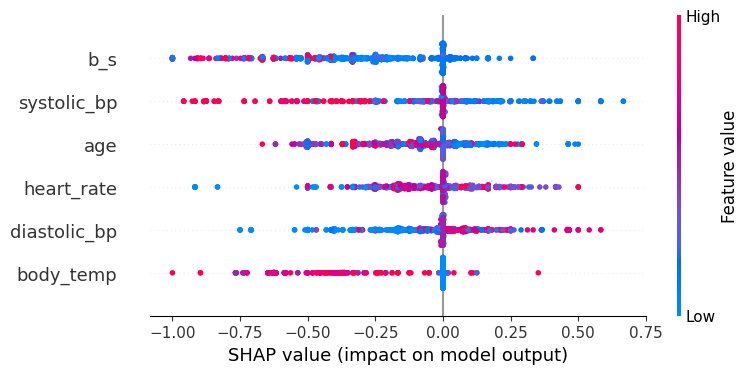

ExactExplainer explainer: 812it [00:23, 19.74it/s]                         


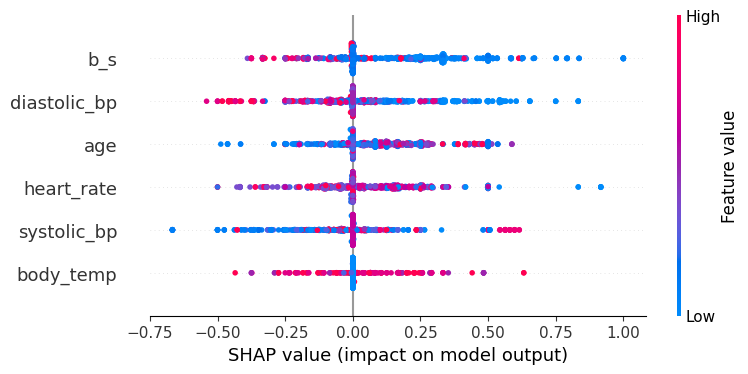

ExactExplainer explainer: 812it [00:23, 19.74it/s]                         


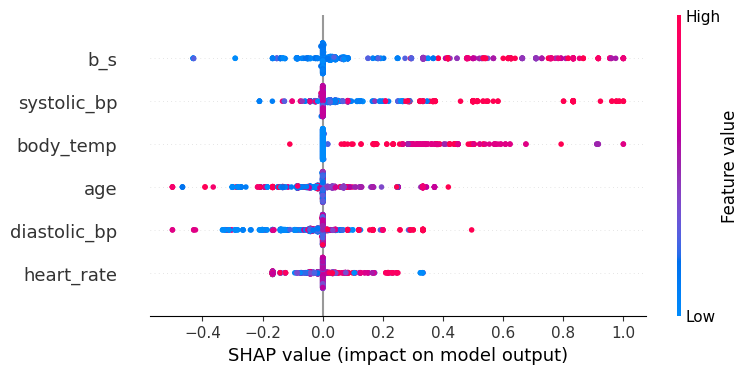

In [27]:
# График важности показателей
def f_0(x):
    return knn_model_grid.best_estimator_.estimators_[0].predict_proba(x)[:, 1]

def f_1(x):
    return knn_model_grid.best_estimator_.estimators_[1].predict_proba(x)[:, 1]

def f_2(x):
    return knn_model_grid.best_estimator_.estimators_[2].predict_proba(x)[:, 1]

med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer_0 = shap.Explainer(f_0, med)
shap_values_0 = explainer_0(X_test)
shap.plots.beeswarm(shap_values_0)

explainer_1 = shap.Explainer(f_1, med)
shap_values_1 = explainer_1(X_test)
shap.plots.beeswarm(shap_values_1)

explainer_2 = shap.Explainer(f_2, med)
shap_values_2 = explainer_2(X_test)
shap.plots.beeswarm(shap_values_2)


**Вывод** \
Модель KNN показала результат значительно лучший, чем модель логистической регрессии. F1-macro для лучшей модели составляет 0.824. В лучшей модели расстояние между "соседями" рассчитывалось с помощью евклидового расстояния, а количество "соседей", по которым производилось усреднение результата - 2.

### Случайный лес

In [28]:
rf_model = OneVsRestClassifier(RandomForestClassifier())
param_grid = {'estimator__criterion':['gini', 'entropy', 'log_loss'],
              'estimator__n_estimators':[100, 150, 200],
              'estimator__max_depth':[None, 2, 5, 10],
              'estimator__min_samples_split':[2, 4],
              'estimator__min_samples_leaf':[1, 2],
              'estimator__max_features':['sqrt', 'log2'],
              'estimator__bootstrap':[True, False],
              'estimator__class_weight':[None, 'balanced', 'balanced_subsample'],
              'estimator__n_jobs':[-1],
              'estimator__random_state':[123]}

rf_model_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_macro')
rf_model_grid.fit(X_train, y_train)
print("Лучший F1 macro:", rf_model_grid.best_score_)
print("Лучшее сочетание гиперпараметров:", rf_model_grid.best_params_)

Лучший F1 macro: 0.831542034137579
Лучшее сочетание гиперпараметров: {'estimator__bootstrap': False, 'estimator__class_weight': None, 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__random_state': 123}


''

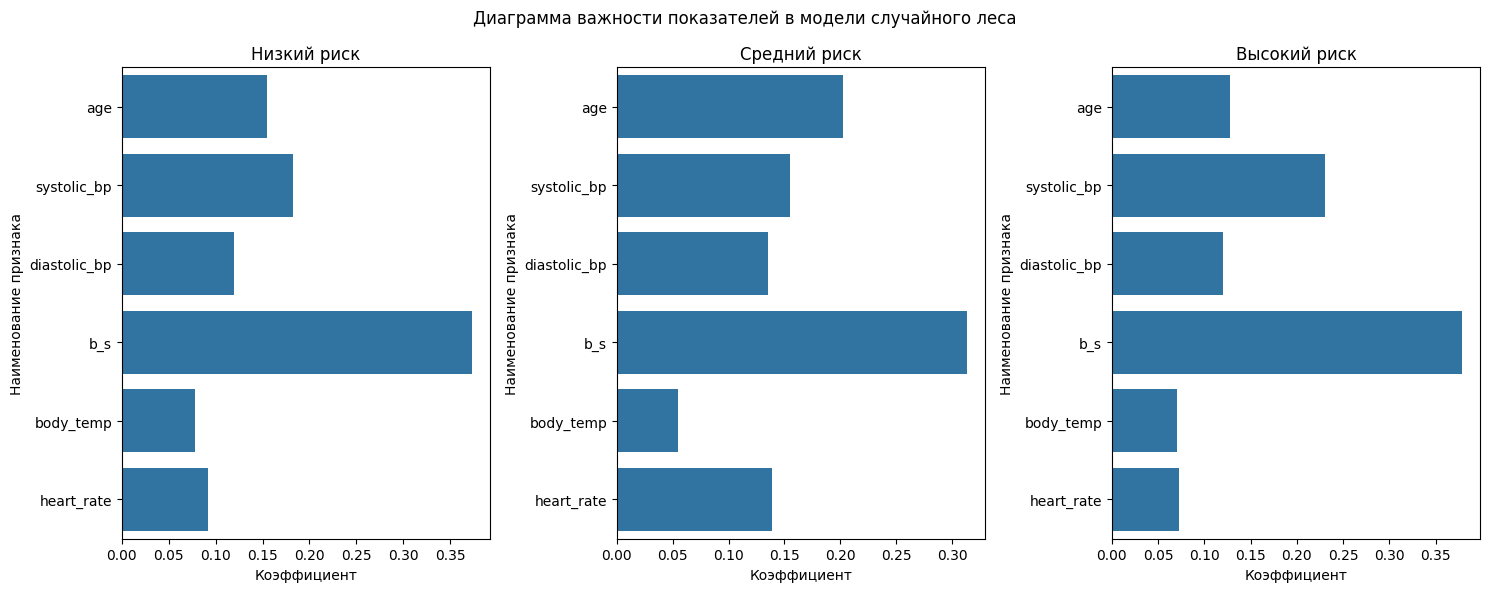

In [34]:
# График важности показателей
fig = plt.figure(figsize=(15, 6), layout='tight')
plt.suptitle("Диаграмма важности показателей в модели случайного леса")

ax1 = fig.add_subplot(1, 3, 1)
rf_model_coef = pd.DataFrame(data=rf_model_grid.best_estimator_.estimators_[0].feature_importances_, columns=['coef'])
columns = pd.DataFrame(data=list(X_train.columns), columns=['columns'])
coef_table = columns.join(rf_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title('Низкий риск')

ax2 = fig.add_subplot(1, 3, 2)
rf_model_coef = pd.DataFrame(data=rf_model_grid.best_estimator_.estimators_[1].feature_importances_, columns=['coef'])
columns = pd.DataFrame(data=list(X_train.columns), columns=['columns'])
coef_table = columns.join(rf_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title('Средний риск')

ax3 = fig.add_subplot(1, 3, 3)
rf_model_coef = pd.DataFrame(data=rf_model_grid.best_estimator_.estimators_[2].feature_importances_, columns=['coef'])
columns = pd.DataFrame(data=list(X_train.columns), columns=['columns'])
coef_table = columns.join(rf_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title('Высокий риск')
;

**Вывод** \
Модель случайного леса показала результат лучший, чем KNN. F1-macro для лучшей модели составляет 0.832 при гиперпараметрах: {'estimator__bootstrap': False, 'estimator__class_weight': None, 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__random_state': 123}

### CatBoost

In [35]:
catboost_model = CatBoostClassifier()
param_grid = {'n_estimators': [300, 500, 750, 1000],
              'max_depth': [6, 8, 10],
              'verbose': [0],
              'random_state':[123],
              'loss_function':['MultiClass']}
catboost_grid = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5, scoring='f1_macro')
catboost_grid.fit(X_train, y_train)
print("Лучший F1 macro:", catboost_grid.best_score_)
print("Лучшее сочетание гиперпараметров:", catboost_grid.best_params_)

Лучший F1 macro: 0.8306467776306526
Лучшее сочетание гиперпараметров: {'loss_function': 'MultiClass', 'max_depth': 6, 'n_estimators': 500, 'random_state': 123, 'verbose': 0}


''

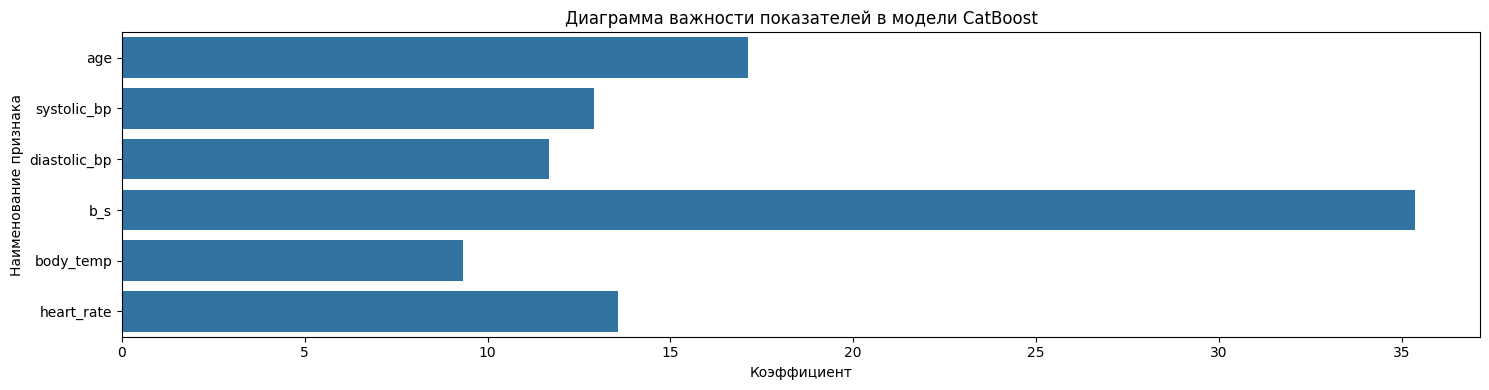

In [41]:
# График важности показателей
fig = plt.figure(figsize=(15, 4), layout='tight')

catboost_model_coef = pd.DataFrame(data=catboost_grid.best_estimator_.get_feature_importance(), columns=['coef'])
columns = pd.DataFrame(data=list(X_train.columns), columns=['columns'])
coef_table = columns.join(catboost_model_coef)
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient='h')
plt.ylabel('Наименование признака')
plt.xlabel('Коэффициент')
plt.title("Диаграмма важности показателей в модели CatBoost")
;

**Вывод:** Модель CatBoost показала результат немного хуже, чем случайный лес. Но в целом, разница между моделями не такая значительная, чтобы признавать модель CatBoost не оптимальной. F1-macro для лучшей модели CatBoost составил 0.831, при гиперпараметрах модели: {'loss_function': 'MultiClass', 'max_depth': 6, 'n_estimators': 500, 'random_state': 123, 'verbose': 0}.

## Тестирование модели

Лучший результат показала модель случайного леса.

----------------------------------------------------------------------------------------------------------------------------------------
F1-macro для тестовой выборки: 0.9299187537926766
----------------------------------------------------------------------------------------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       325
           1       0.88      0.95      0.91       274
           2       0.93      0.96      0.95       212

    accuracy                           0.93       811
   macro avg       0.93      0.93      0.93       811
weighted avg       0.93      0.93      0.93       811

----------------------------------------------------------------------------------------------------------------------------------------


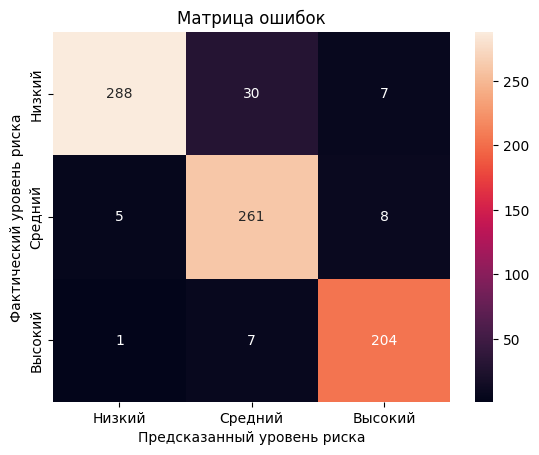

In [42]:
# Получим предсказание для тестовой выборки
pred = rf_model_grid.best_estimator_.predict(X_test)

print('----------------------------------------------------------------------------------------------------------------------------------------')
print(f"\033[1m{'F1-macro для тестовой выборки:'}\033[0m", f1_score(y_test, pred, average='macro'))
print('----------------------------------------------------------------------------------------------------------------------------------------')
print(f"\033[1m{'Classification report'}\033[0m")
print(classification_report(y_test, pred))
print('----------------------------------------------------------------------------------------------------------------------------------------')
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred), annot=True, ax=ax, fmt='d');
ax.set_xlabel("Предсказанный уровень риска")
ax.set_ylabel("Фактический уровень риска")
ax.set_title("Матрица ошибок")
ax.xaxis.set_ticklabels(["Низкий", "Средний", "Высокий"])
ax.yaxis.set_ticklabels(["Низкий", "Средний", "Высокий"]);

**Вывод:** Метрика на тестовой выборке превысила метрику на обучающей выборке, и составила: F1=0.93. Модель хорошо распознает классы, но часть женщин с низким уровнем риска перемещает в группу среднего уровня риска. Из плюсов модели можно отметить, что модель практически не присваивает уровень риска меньший, чем он есть на самом деле.

## Общий вывод

**1. Обзор данных**
* В данных содержится 1014 наблюдений и 6 количественных показателей;
* Ключевой показатель: уровень риска. В данных есть низкий, средний и высокий риск;
* В рамках исследования была решена задача многоклассовой классификации.

**2. Исследование данных**
* В данных есть дисбаланс классов. Чтобы каждый класс в равной степени вносил свой вклад в итоговую метрику, целевой метрикой выбрана метрика F1-macro;
* В основном в выборке содержатся данные по женщинам в возрасте от 19 до 38 лет. В группы с низким и средним риском в основном входят женщины возраста от 19 до 32, а в группу с высоким риском - женщины от 25 до 48 и выше. Группа с возрастом более 35 лет составляют не такую большую величину, и поэтому может быть подвержена выбросам.
* В основном в выборке систолическое давление находится в диапазоне от 95 до 120 (при норме от 90 до 140), а диастолическое - от 65 до 90 (при норме от 60 до 90). Разница между ними находится в основном в диапазоне от 30 до 40 (пр норме от 30 до 50). Из распределений показателей систолического и диастолического давления видно, что низкое давление не сильно влияет на риск, связанный с беременностью. При этом высокое систолическое давление (выше 120) означает высокий или средний риск.
* В данных по уровню сахара в крови основной диапазон значений лежит в пределах от 6.9 до 7.95 ммоль/литр, что странно, так как общепринятой величиной уровня сахара в крови является значение между 4.4 и 6.1. Тем не менее, из распределения видно, что для низкого и среднего показателя риска основные значения лежат в диапазоне до 8 ммоль/литр, а показатели для высокого риска - в диапазоне от 8 и выше.
* Показатель температуры тела не сильно влияет на риск, связанный с беременностью. Но это связано скорее с тем, что в выборке мало строк с повышенной температурой. Тем не менее, при температуре выше 99 риск, связанный с беременностью, выше.
* Чем выше пульс, тем сильнее повышается риск для беременности. При этом, наличие нормального пульса еще не означает отсутствия рисков для беременности.
* Сильнее всего на показатель риска влияют показатели систолического давления, уровень сахара в крови, диастолического давления. Слабее всего - высокая температура;
* Показатели систолического, диастолического давления сильно коррелируют между собой;
* Выявлено, что основные риски при беременности для женщин < 20 лет составляют высокая температура и высокий уровень сахара в крови. Для женщин от 20 до 45 лет: высокое давление и высокий уровень сахара в крови. Для женщин от 45 лет: высокий уровень сахара в крови, высокий пульс, высокое давление.
  
**3. Предобработка данных** \
На этапе предобработки данных было проведено:
* Разделение датасета на обучающую и тестовую выборку;
* Изменение подписей столбцов;
* Исправление опечаток в heart_rate;
* Показатель уровня риска был закодирован числами 0 (низкий риск), 1 (средний риск), 2 (высокий риск);
* Нормализация данных.

**4. Обучение моделей** \
Было обучено 4 модели, на которых получены следующиее результаты:
* Логистическая регрессия: F1-macro=0.641 при гиперпараметрах {'estimator__C': 0.01, 'estimator__class_weight': None, 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'liblinear'};
* KNN: F1-macro=0.811 при гиперпараметрах {'estimator__n_jobs': -1, 'estimator__n_neighbors': 2, 'estimator__p': 2, 'estimator__weights': 'distance'}
* Случайный лес: F1-macro=0.832 при гиперпараметрах: {'estimator__bootstrap': False, 'estimator__class_weight': None, 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__random_state': 123}
* CatBoost: F1-macro=0.831, при гиперпараметрах модели: {'loss_function': 'MultiClass', 'max_depth': 6, 'n_estimators': 500, 'random_state': 123, 'verbose': 0}.
Лучшей моделью была выбрана модель случайного леса.

**5. Результат тестирования** \
Метрика на тестовой выборке превысила метрику на обучающей выборке, и составила: F1-macro=0.93. Модель хорошо распознает классы, но часть женщин с низким уровнем риска перемещает в группу среднего уровня риска. Из плюсов модели можно отметить, что модель практически не присваивает уровень риска меньший, чем он есть на самом деле. Наиболее важными признаками для диагностирования высокого уровня риска являются уровень сахара в крови и артериальное давление.